# Rolling Planning mit Lateness (Tardiness + Earliness)

In [31]:
max_time = 60*45 # 3/4h

In [3]:
import time

from ortools.sat.python import cp_model
import pandas as pd
import numpy as np
import math

pd.set_option('display.max_rows', 20)


import utils.presenter as show
import utils.checker as check

import utils.scheduling_solver as ssv
import utils.rescheduling_solver_lateness as rssv

import utils.rolling_planning.init_jobs_times as rp_init
import utils.rolling_planning.procedure as rp_proced
import utils.schedule_deadline as deadline_gen

from ProductionDaySimulation import ProductionDaySimulation

In [4]:
start_notebook = time.time()

In [5]:
def get_schedule_filename(prefix: str = "", day: int = 0, data_txt: str = "schedule", suffix: str = "") -> str:
    file_template = "data/{prefix}_{data}_{day:02d}{suffix}.csv"
    if suffix:
        suffix = f"_{suffix}"
    return file_template.format(prefix=prefix,data=data_txt,day=day, suffix=suffix)

## Generierung des Datensatzes für 10 Tage (Ankunft)

In [7]:
df_instance = pd.read_csv("data/00_instance.csv")

df_jssp, df_arrivals = rp_init.init_jobs_with_arrivals(df_instance, 10,  u_b_mmax = 0.98)
df_jssp

Job Operation Machine Processing Time
0     Job_000         0      M0              29
1     Job_000         1      M1              78
2     Job_000         2      M2               9
3     Job_000         3      M3              36
4     Job_000         4      M4              49
...       ...       ...     ...             ...
1895  Job_189         5      M9              76
1896  Job_189         6      M5              47
1897  Job_189         7      M3              52
1898  Job_189         8      M4              90
1899  Job_189         9      M7              45

[1900 rows x 4 columns]

In [8]:
# Deadlines + Umwandlung in Integer
df_times = deadline_gen.get_times_df(df_jssp, df_arrivals, ssv.schedule_fcfs_with_arrivals, target_service=1)
df_times["Arrival"] = np.floor(df_times["Arrival"]).astype(int)
df_times["Deadline"] = np.ceil(df_times["Deadline"]).astype(int)
df_times

Job  Arrival  Deadline
0    Job_000        0      1244
1    Job_001       80      1687
2    Job_002      140      1929
3    Job_003      191      2254
4    Job_004      226      1465
..       ...      ...       ...
185  Job_185    14053     16117
186  Job_186    14059     15298
187  Job_187    14060     15850
188  Job_188    14176     15420
189  Job_189    14272     15974

[190 rows x 3 columns]

## Params

In [10]:
# fix
day_length = 1440
horizon_days = 3

In [11]:
# init
day_numb = 0

day_start = 0
day_end = 0
planning_end = 0

# Initialisierung (Tag 0)

In [13]:
day_numb = 0

day_start = day_length*day_numb                      # 0
day_end = day_start + day_length                     # 1440
planning_end =  day_start + horizon_days*day_length  # 4320

In [14]:
# I)
df_jssp_curr, df_times_curr = rp_proced.filter_jobs_by_arrival_window(df_times, df_jssp, day_start, planning_end)
df_jssp_curr

Job Operation Machine Processing Time
0    Job_000         0      M0              29
1    Job_000         1      M1              78
2    Job_000         2      M2               9
3    Job_000         3      M3              36
4    Job_000         4      M4              49
..       ...       ...     ...             ...
565  Job_056         5      M9              76
566  Job_056         6      M5              47
567  Job_056         7      M3              52
568  Job_056         8      M4              90
569  Job_056         9      M7              45

[570 rows x 4 columns]

In [15]:
df_times_curr 

Job  Arrival  Deadline
0   Job_000        0      1244
1   Job_001       80      1687
2   Job_002      140      1929
3   Job_003      191      2254
4   Job_004      226      1465
..      ...      ...       ...
52  Job_052     3973      6037
53  Job_053     3979      5218
54  Job_054     3980      5770
55  Job_055     4096      5340
56  Job_056     4192      5894

[57 rows x 3 columns]

### Scheduling

In [17]:
starting_time = time.time()

# Scheduling
df_plan = ssv.solve_cp_jssp_lateness_by_tardiness_and_earliness(df_jssp_curr, df_times_curr,
                                                                w_t = 5,
                                                                msg=False, timeLimit=max_time, gapRel= 0.00)
df_plan

# Informationen
ending_time = time.time()
solver_duration = ending_time - starting_time
print(f"\nScheduling-Dauer: {int(solver_duration // 60)} Minuten und {(solver_duration % 60):.2f} Sekunden.")
df_plan


Solver-Status         : OPTIMAL
Objective Value       : 105.00
Best Objective Bound  : 105.00
Laufzeit              : 13.32 Sekunden

Scheduling-Dauer: 0 Minuten und 13.47 Sekunden.


Job  Operation  Arrival  Deadline Machine  Start  Processing Time  \
0    Job_000          0        0      1244      M0      0               29   
1    Job_000          1        0      1244      M1     29               78   
2    Job_001          0       80      1687      M0     80               43   
3    Job_000          2        0      1244      M2    107                9   
4    Job_000          3        0      1244      M3    116               36   
..       ...        ...      ...       ...     ...    ...              ...   
565  Job_051          9     3968      5531      M7   5506               25   
566  Job_049          9     3747      5628      M8   5554               74   
567  Job_054          9     3980      5770      M4   5737               33   
568  Job_056          9     4192      5894      M7   5849               45   
569  Job_052          9     3973      6037      M5   5994               43   

      End  Lateness  Tardiness  Earliness  
0      29     -1215          0       1215  
1     107     -1137          0       1137  
2     123     -1564          0       1564  
3     116     -1128          0       1128  
4     152     -1092          0       1092  
..    ...       ...        ...        ...  
565  5531         0          0          0  
566  5628         0          0          0  
567  5770         0          0          0  
568  5894         0          0          0  
569  6037         0          0          0  

[570 rows x 11 columns]

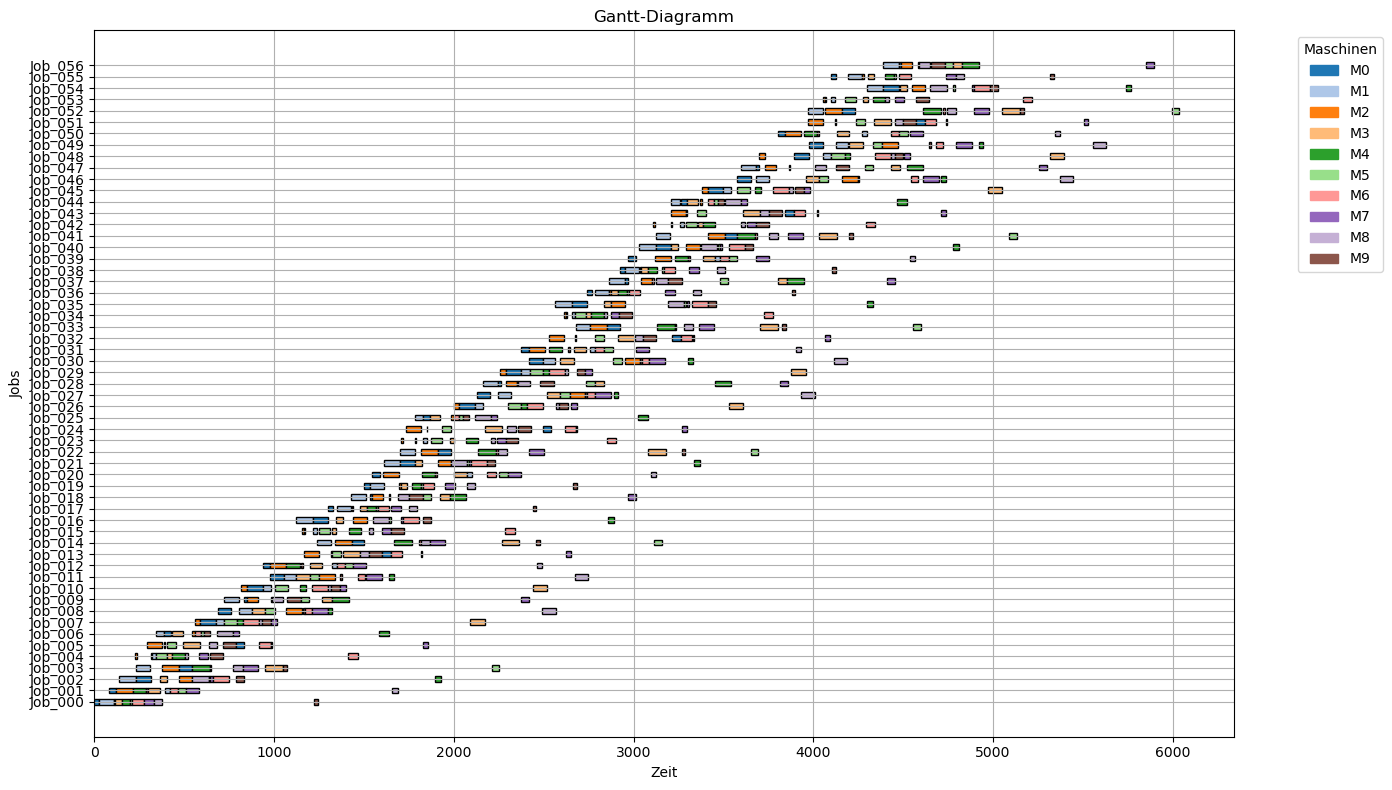

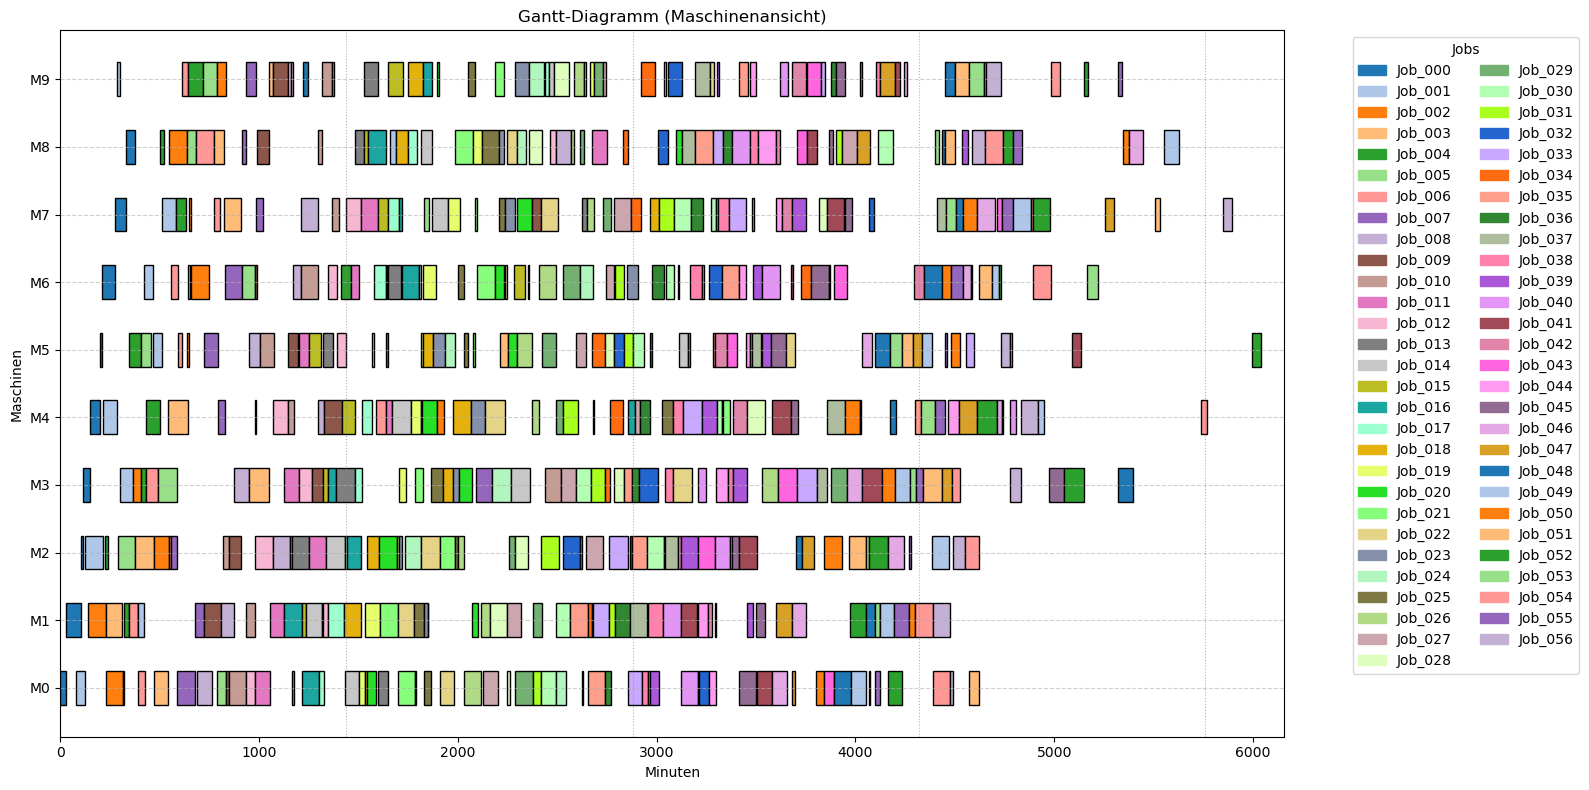

+ Keine Maschinenkonflikte gefunden
+ Für alle Jobs ist die Operationssequenz korrekt.
+ Zeitliche technologische Reihenfolge korrekt.
+ Alle Operation starten erst nach Arrival des Job


True

In [18]:
show.plot_gantt_jobs(df_plan)
show.plot_gantt_machines(df_plan)

check.is_machine_conflict_free(df_plan)
check.is_operation_sequence_correct(df_plan)
check.is_job_timing_correct(df_plan)
check.is_start_correct(df_plan)

In [19]:
last_ops = df_plan.sort_values(['Job', 'Operation']).drop_duplicates('Job', keep='last')
show.count_column_grouped(last_ops, "Lateness", max_val = 90, steps= 30)

label
<-90          0
-90 - -60     0
-60 - -30     3
-30 - 0       0
0            54
0 - 30        0
30 - 60       0
60 - 90       0
>90           0
Name: count, dtype: int32

### Simulation

In [21]:
simulation = ProductionDaySimulation(df_plan, vc=0.35)
df_execution, df_undone = simulation.run(start_time = day_start, end_time=day_end)

[00:00:00] Job_000 started on M0
[00:13:11] Job_000 finished on M0 (after 13 minutes 12 seconds)
[00:29:00] Job_000 started on M1
[01:20:00] Job_001 started on M0
[01:55:19] Job_001 finished on M0 (after 35 minutes 20 seconds)
[02:03:00] Job_001 started on M2
[02:16:13] Job_000 finished on M1 (after 107 minutes 13 seconds)
[02:20:00] Job_002 started on M1
[03:57:14] Job_002 finished on M1 (after 97 minutes 14 seconds)
[03:57:14] Job_003 started on M1
[03:57:14] Job_002 started on M0
[04:16:52] Job_001 finished on M2 (after 133 minutes 52 seconds)
[04:16:52] Job_000 started on M2
[04:16:52] Job_001 started on M4
[04:24:41] Job_000 finished on M2 (after 07 minutes 49 seconds)
[04:24:41] Job_004 started on M2
[04:24:41] Job_000 started on M3
[04:43:51] Job_004 finished on M2 (after 19 minutes 10 seconds)
[04:52:25] Job_000 finished on M3 (after 27 minutes 44 seconds)
[04:53:00] Job_005 started on M2
[05:18:54] Job_001 finished on M4 (after 62 minutes 02 seconds)
[05:18:54] Job_000 started

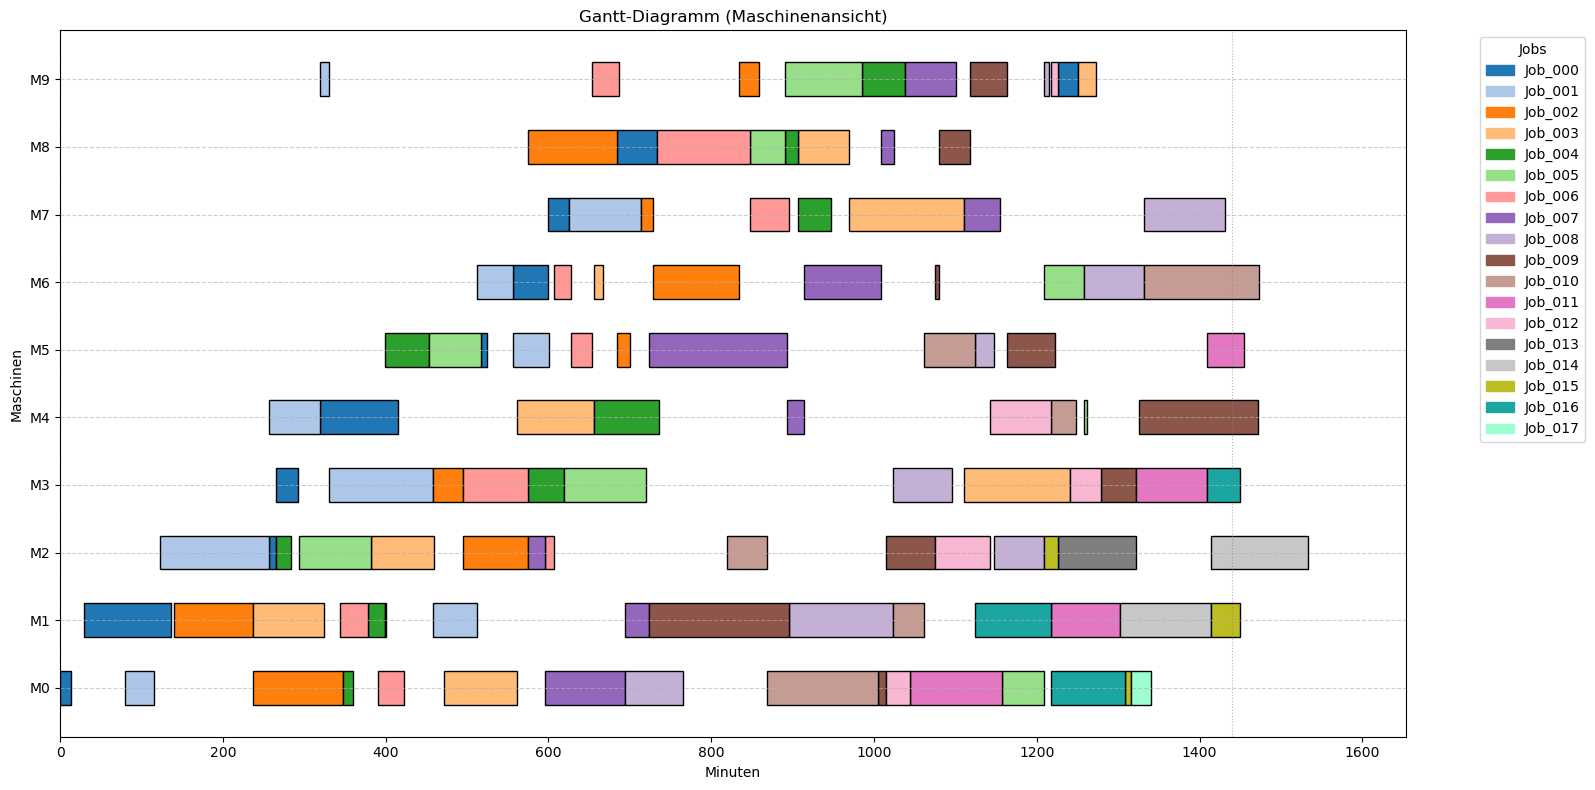

In [22]:
if not df_execution.empty:
    show.plot_gantt_machines(df_execution, duration_column="Simulated Processing Time")
else:
    print(f"Nothing executed on day {day_numb}")

In [23]:
df_undone

Job  Operation  Arrival Machine  Planned Start  Processing Time
0    Job_015          3     1099      M5           1251               61
1    Job_011          4      867      M2           1252               85
2    Job_010          6      819      M8           1298               19
3    Job_008          8      687      M4           1299               26
4    Job_010          7      819      M9           1317               48
..       ...        ...      ...     ...            ...              ...
450  Job_051          9     3968      M7           5506               25
451  Job_049          9     3747      M8           5554               74
452  Job_054          9     3980      M4           5737               33
453  Job_056          9     4192      M7           5849               45
454  Job_052          9     3973      M5           5994               43

[455 rows x 6 columns]

In [24]:
df_plan.to_csv(get_schedule_filename("06", day=day_numb, suffix="init"), index = False)

In [25]:
df_plan_init = df_plan
df_execution_init = df_execution

## A) Rolling Planning Simple

**Zielfunktion:**

Minimiere die gewichtete Summe aus Tardiness und Earliness der Jobs:

\\[
Z(\sigma) = \sum_{j} \left( w_t \cdot \text{Tardiness}_j + w_e \cdot \text{Earliness}_j \right)
\\]

wobei:

- \\( w_t \in \mathbb{N},\ w_e \in \mathbb{N} \\): Gewicht für Tardiness und Earliness  
- \\( \text{Tardiness}_j = \max(0, C_j - d_j) \\), \\( \text{Earliness}_j = \max(0, d_j - C_j) \\)  
    - \\( C_j \\): Fertigstellungszeitpunkt der letzten Operation von Job \\( j \\)  
    - \\( d_j \\): Deadline für Job \\( j \\)


Solver-Status         : OPTIMAL
Objective Value       : 445.00
Best Objective Bound  : 445.00
Laufzeit              : 14.36 Sekunden

  Scheduling-Dauer: 0 Minuten und 14.71 Sekunden.


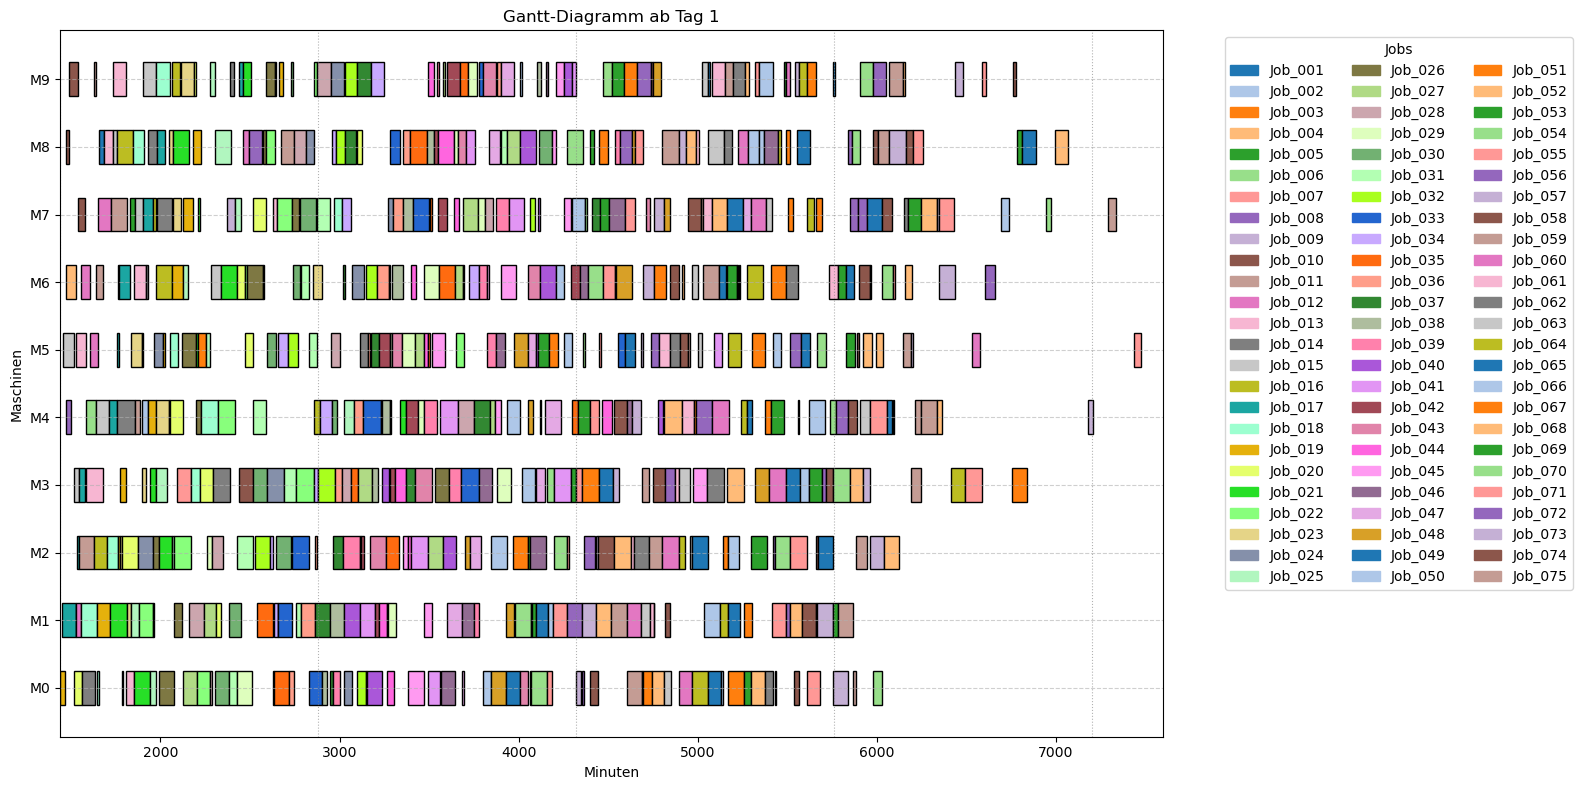

+ Keine Maschinenkonflikte gefunden
+ Für alle Jobs ist die Operationssequenz korrekt.
+ Zeitliche technologische Reihenfolge korrekt.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.

label
<-180           0
-180 - -120     0
-120 - -60      0
-60 - 0         4
0              70
0 - 60          0
60 - 120        1
120 - 180       0
>180            0
Name: count, dtype: int32
[24:00:00] Job_019 started on M0
[24:10:00] Job_017 started on M1
[24:12:54] Job_019 finished on M0 (after 12 minutes 54 seconds)
[24:16:00] Job_015 started on M5
[24:32:00] Job_008 started on M4
[24:33:00] Job_004 started on M6
[24:33:00] Job_010 started on M8
[24:46:34] Job_008 finished on M4 (after 14 minutes 34 seconds)
[24:58:52] Job_015 finished on M5 (after 42 minutes 53 seconds)
[25:07:13] Job_010 finished on M8 (after 34 minutes 13 seconds)
[25:07:13] Job_010 started on M9
[25:17:00] Job_015 started on M3
[25:20:00] Job_020 started on M0
[25:38:12] Job_004 finished 

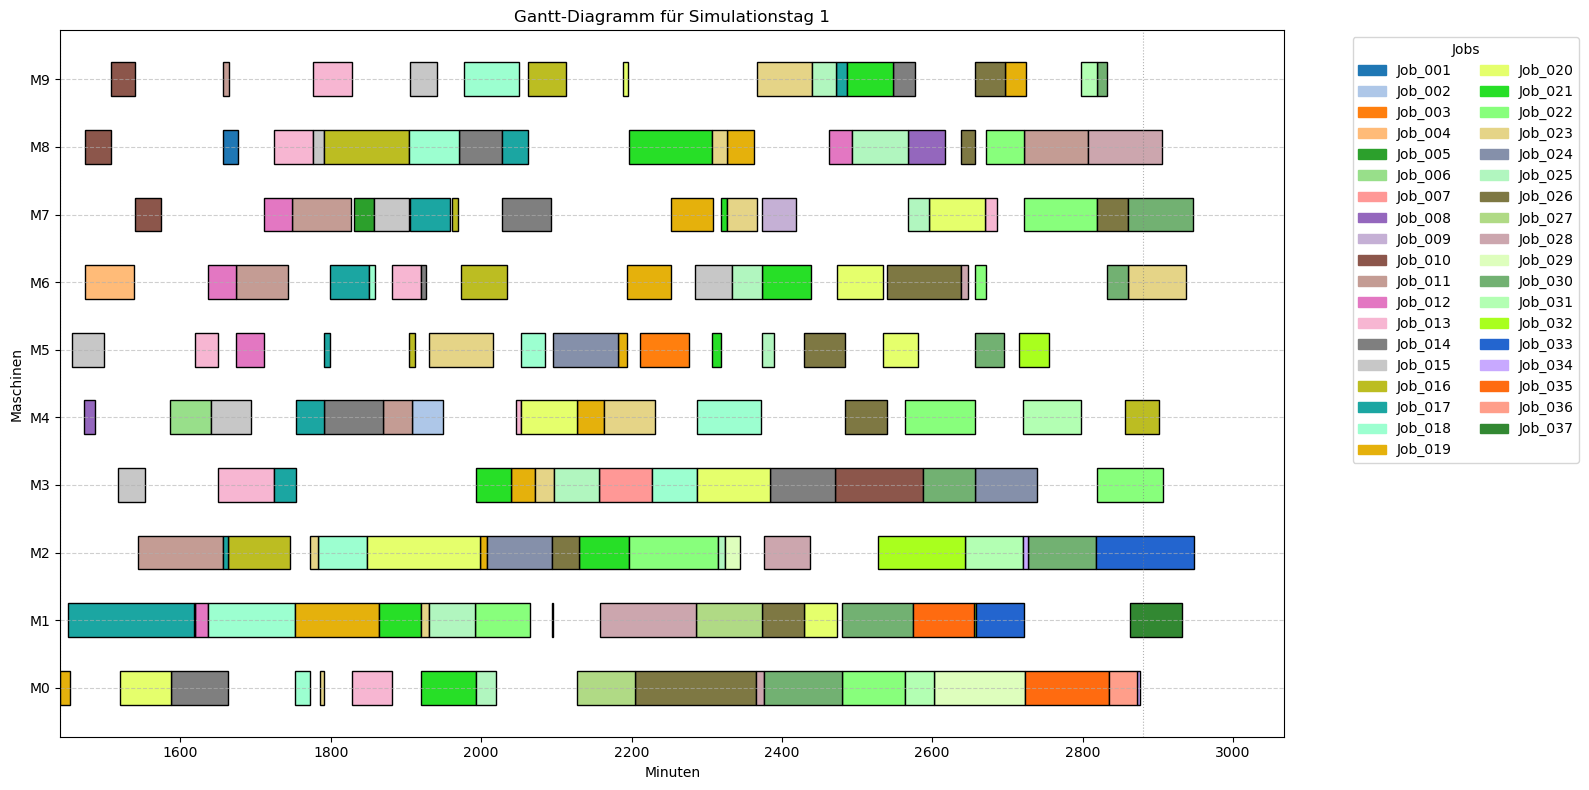


Solver-Status         : OPTIMAL
Objective Value       : 140.00
Best Objective Bound  : 140.00
Laufzeit              : 21.75 Sekunden

  Scheduling-Dauer: 0 Minuten und 22.08 Sekunden.


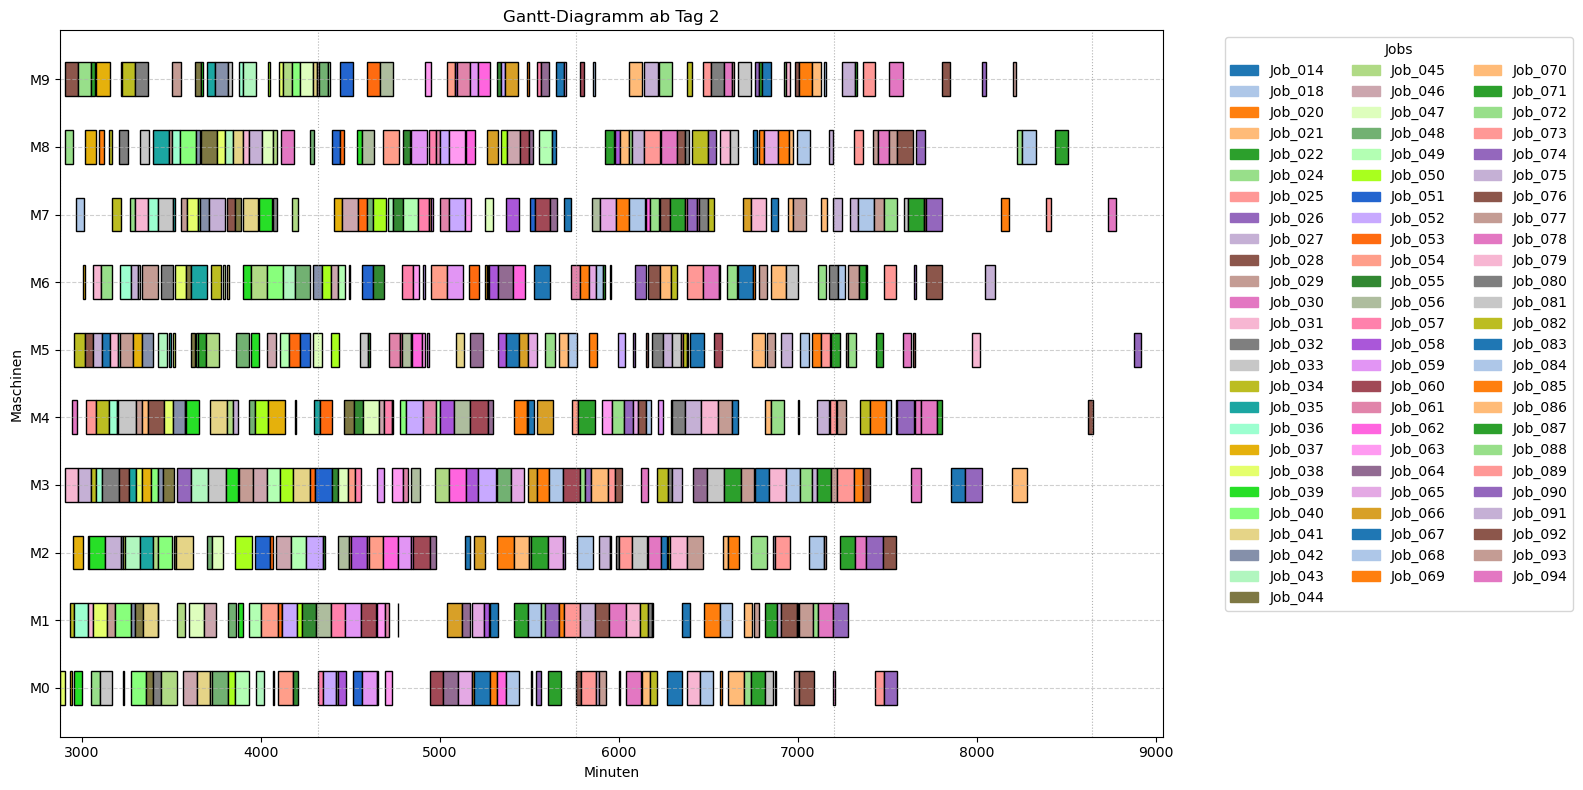

+ Keine Maschinenkonflikte gefunden
+ Für alle Jobs ist die Operationssequenz korrekt.
+ Zeitliche technologische Reihenfolge korrekt.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.

label
<-180           0
-180 - -120     0
-120 - -60      0
-60 - 0         4
0              72
0 - 60          0
60 - 120        0
120 - 180       0
>180            0
Name: count, dtype: int32
[48:00:00] Job_038 started on M0
[48:20:26] Job_038 finished on M0 (after 20 minutes 27 seconds)
[48:26:00] Job_024 started on M8
[48:26:00] Job_028 started on M9
[48:28:00] Job_031 started on M3
[48:53:00] Job_034 started on M1
[48:53:00] Job_037 started on M0
[49:00:45] Job_024 finished on M8 (after 34 minutes 45 seconds)
[49:01:13] Job_037 finished on M0 (after 08 minutes 13 seconds)
[49:07:00] Job_030 started on M4
[49:09:00] Job_037 started on M2
[49:10:19] Job_034 finished on M1 (after 17 minutes 19 seconds)
[49:15:00] Job_036 started on M1
[49:15:00] Job_034 started o

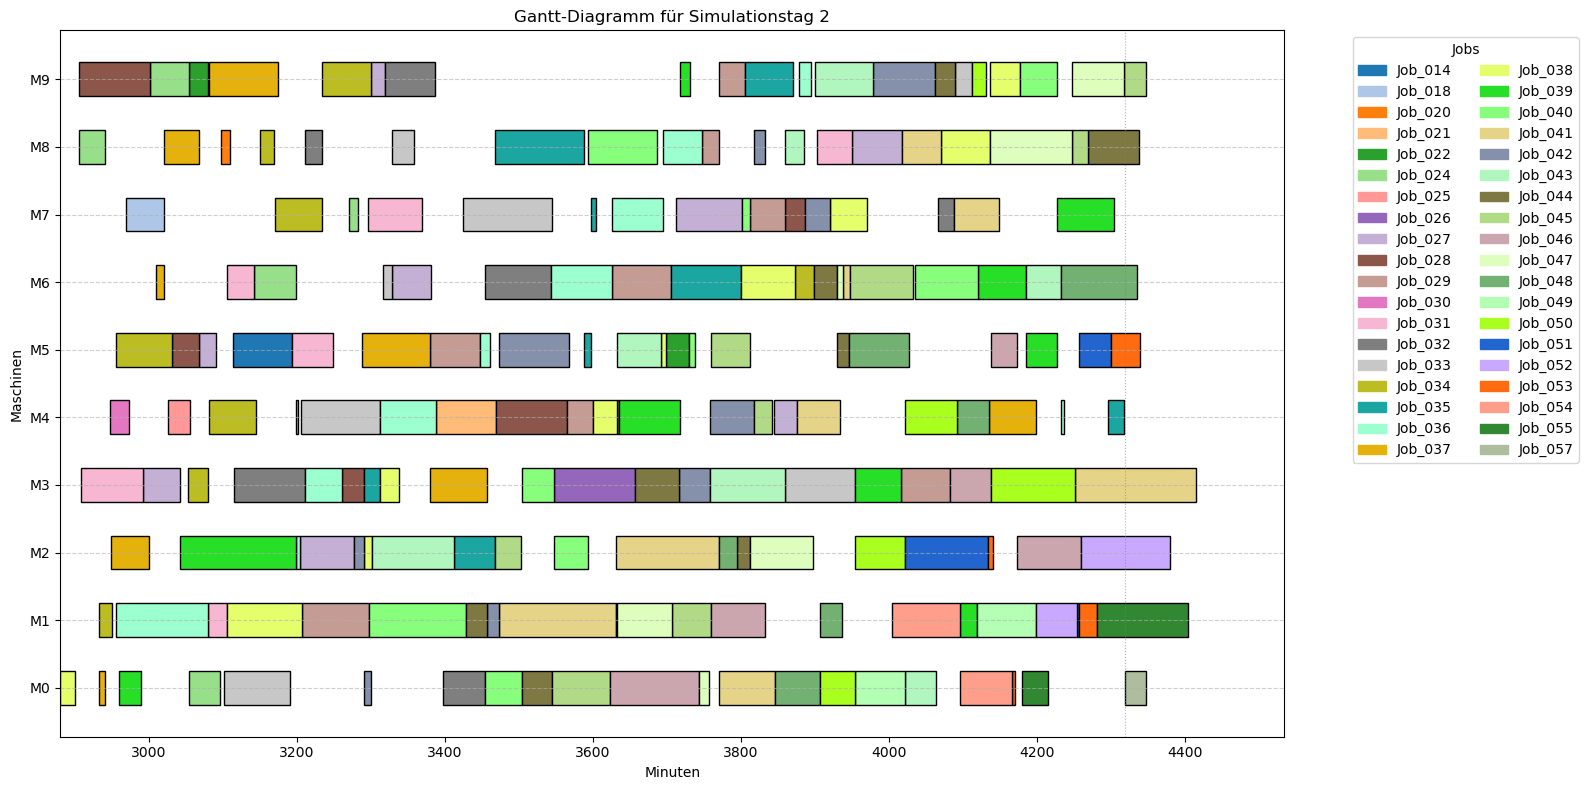


Solver-Status         : OPTIMAL
Objective Value       : 1485.00
Best Objective Bound  : 1485.00
Laufzeit              : 17.18 Sekunden

  Scheduling-Dauer: 0 Minuten und 17.50 Sekunden.


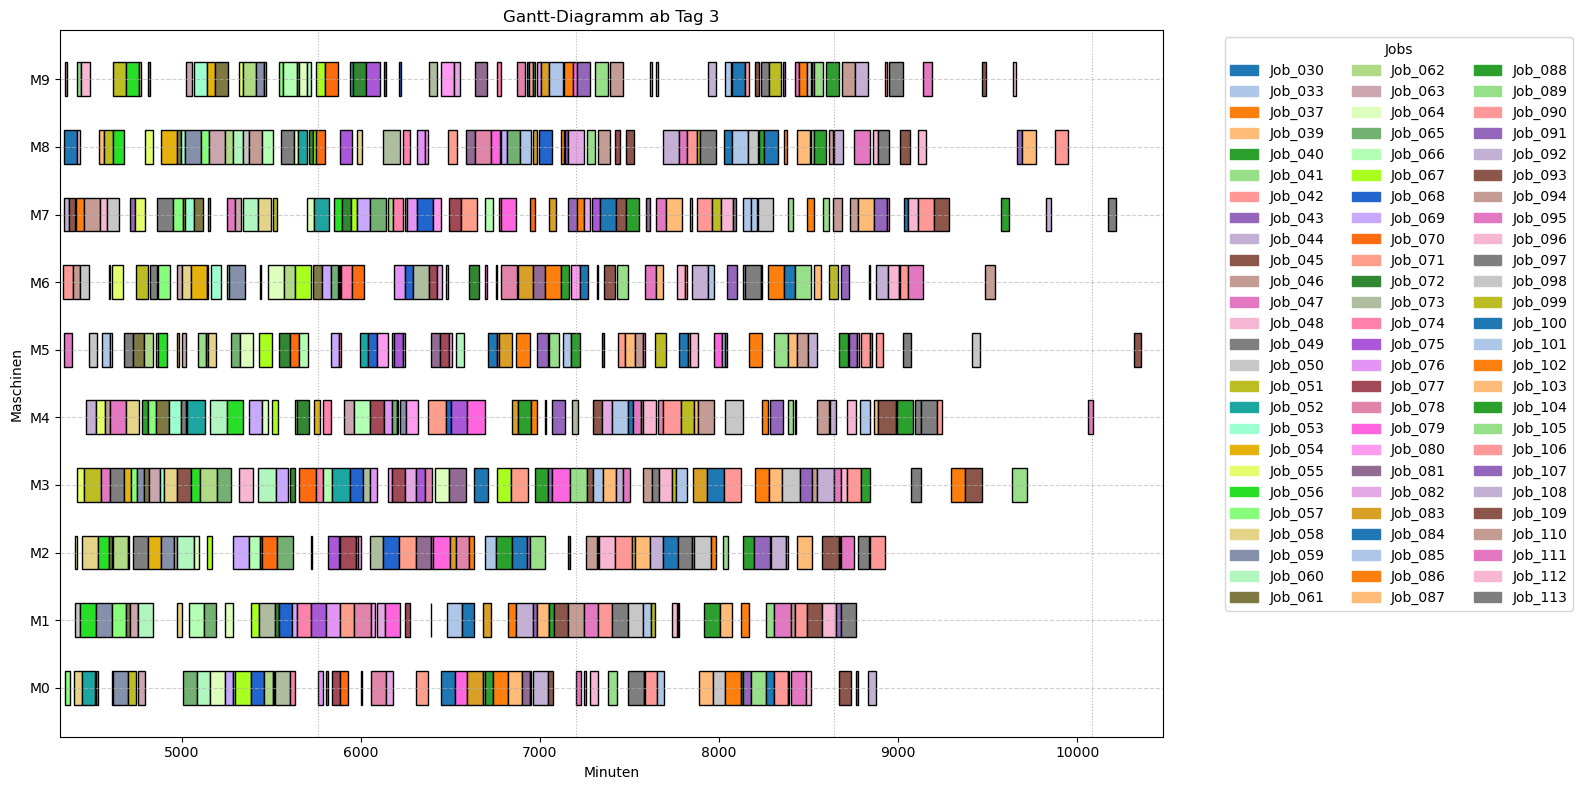

+ Keine Maschinenkonflikte gefunden
+ Für alle Jobs ist die Operationssequenz korrekt.
+ Zeitliche technologische Reihenfolge korrekt.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.

label
<-180           0
-180 - -120     0
-120 - -60      0
-60 - 0         4
0              72
0 - 60          1
60 - 120        0
120 - 180       0
>180            1
Name: count, dtype: int32
[72:16:00] Job_042 started on M6
[72:19:00] Job_030 started on M8
[72:19:00] Job_044 started on M7
[72:21:00] Job_047 started on M5
[72:28:00] Job_057 started on M0
[72:29:00] Job_046 started on M9
[72:39:11] Job_046 finished on M9 (after 10 minutes 11 seconds)
[72:40:30] Job_044 finished on M7 (after 21 minutes 30 seconds)
[72:49:00] Job_045 started on M7
[72:56:05] Job_057 finished on M0 (after 28 minutes 05 seconds)
[73:01:15] Job_030 finished on M8 (after 42 minutes 15 seconds)
[73:16:25] Job_047 finished on M5 (after 55 minutes 25 seconds)
[73:20:00] Job_058 started on 

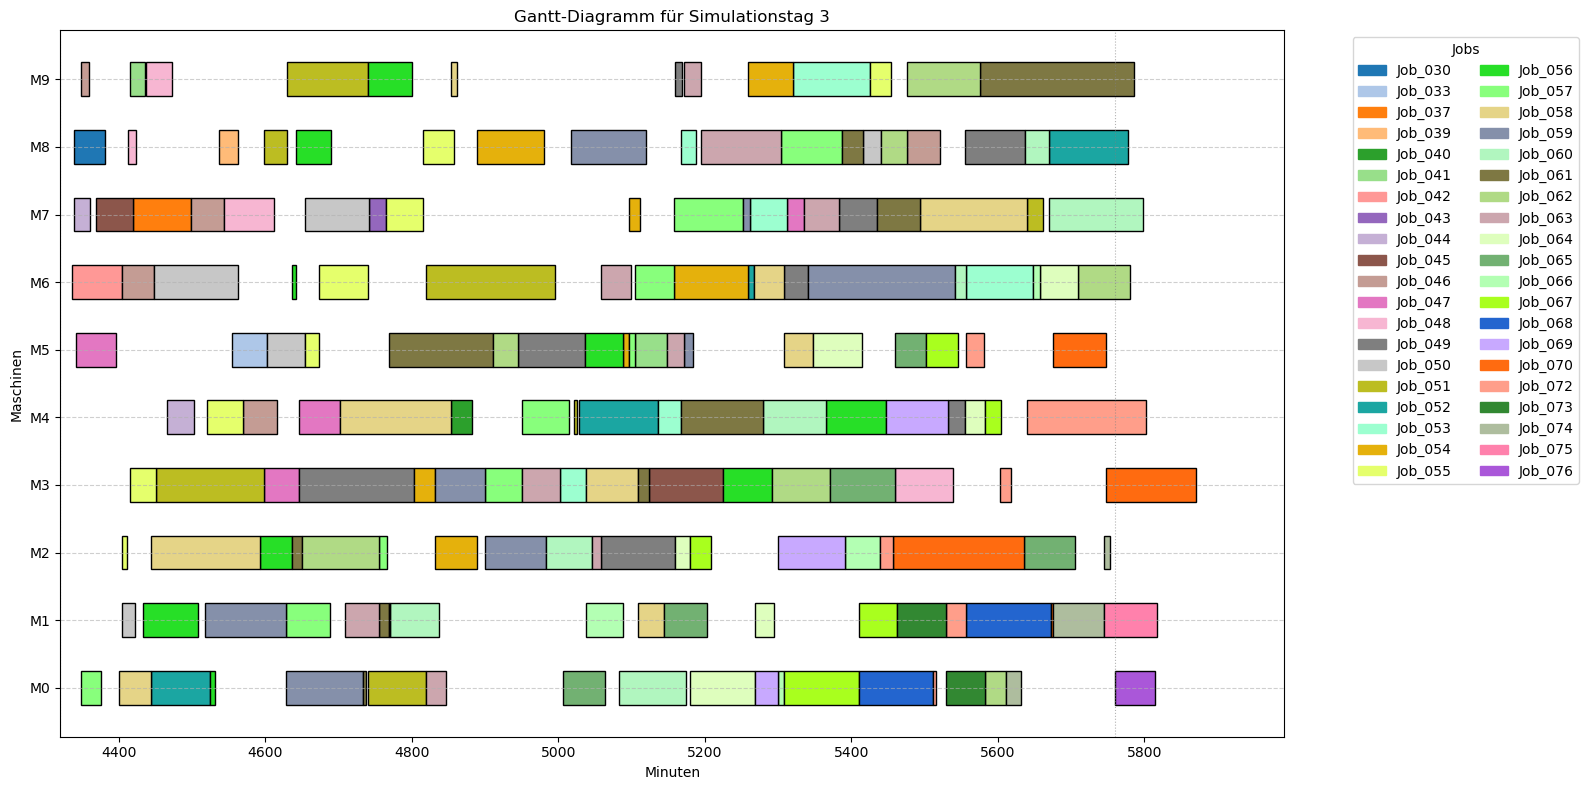


Solver-Status         : OPTIMAL
Objective Value       : 2180.00
Best Objective Bound  : 2180.00
Laufzeit              : 21.42 Sekunden

  Scheduling-Dauer: 0 Minuten und 21.82 Sekunden.


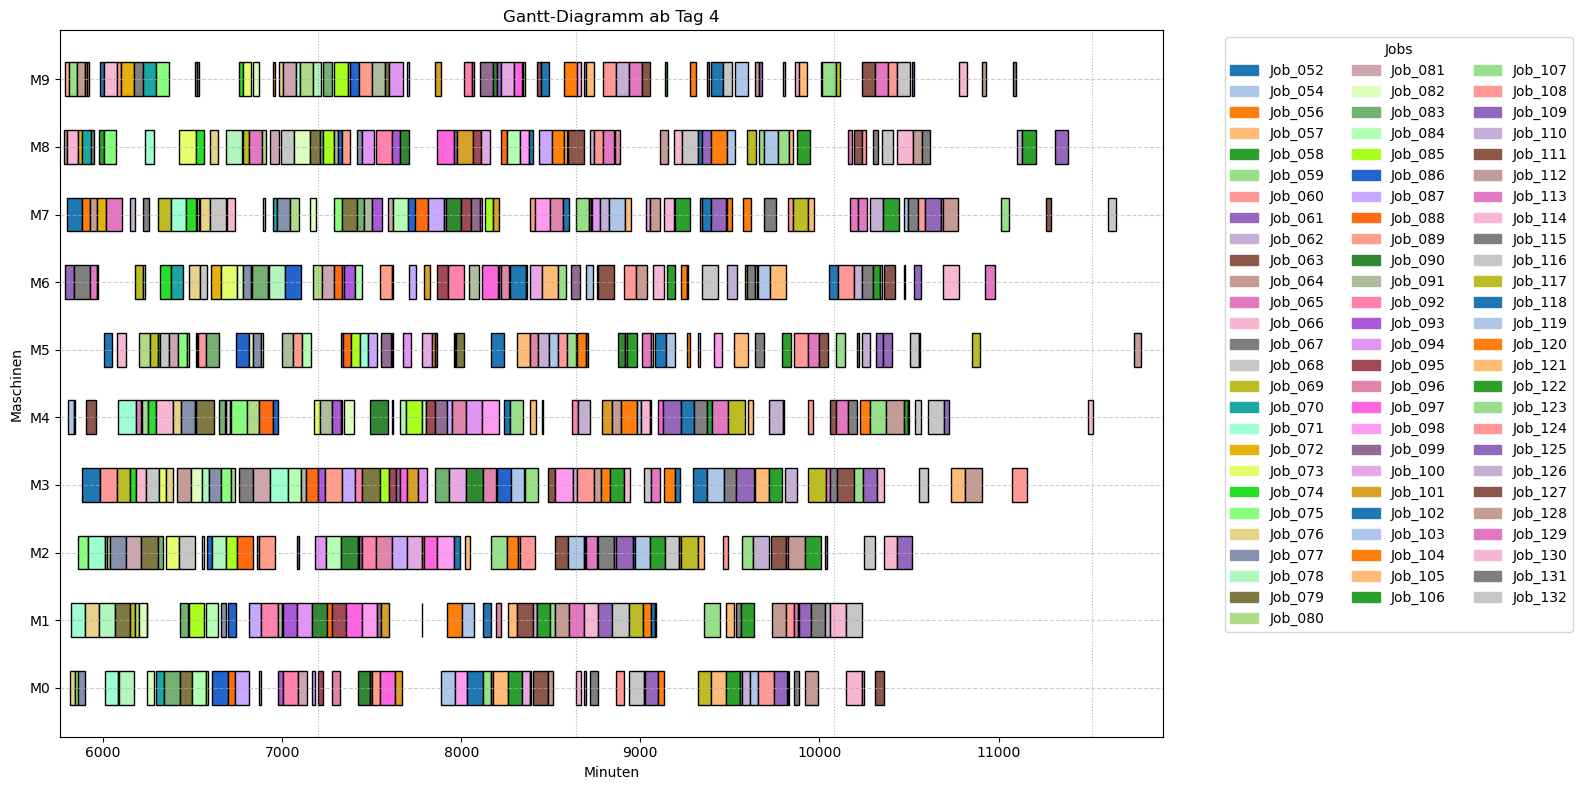

+ Keine Maschinenkonflikte gefunden
+ Für alle Jobs ist die Operationssequenz korrekt.
+ Zeitliche technologische Reihenfolge korrekt.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.

label
<-180           0
-180 - -120     0
-120 - -60      0
-60 - 0         4
0              70
0 - 60          3
60 - 120        1
120 - 180       0
>180            1
Name: count, dtype: int32
[96:19:00] Job_064 started on M8
[96:26:00] Job_057 started on M9
[96:26:00] Job_061 started on M6
[96:39:00] Job_052 started on M7
[96:39:15] Job_064 finished on M8 (after 20 minutes 15 seconds)
[96:39:15] Job_066 started on M8
[96:43:00] Job_054 started on M4
[96:43:07] Job_057 finished on M9 (after 17 minutes 07 seconds)
[96:47:00] Job_059 started on M9
[96:55:00] Job_076 started on M0
[96:58:00] Job_071 started on M1
[97:15:18] Job_076 finished on M0 (after 20 minutes 19 seconds)
[97:20:06] Job_052 finished on M7 (after 41 minutes 06 seconds)
[97:24:00] Job_075 started o

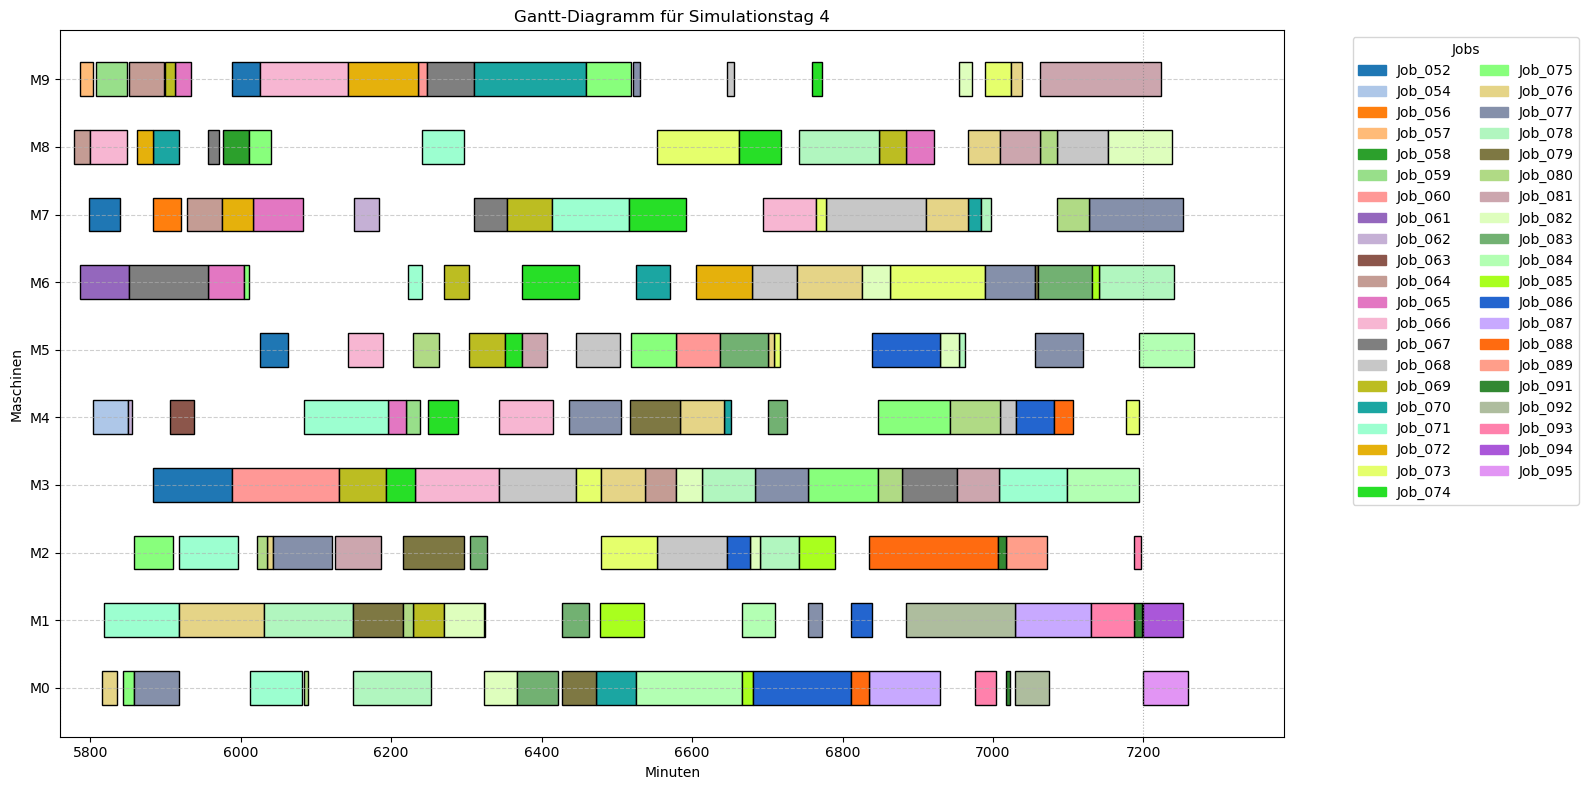


Solver-Status         : OPTIMAL
Objective Value       : 755.00
Best Objective Bound  : 755.00
Laufzeit              : 28.71 Sekunden

  Scheduling-Dauer: 0 Minuten und 29.08 Sekunden.


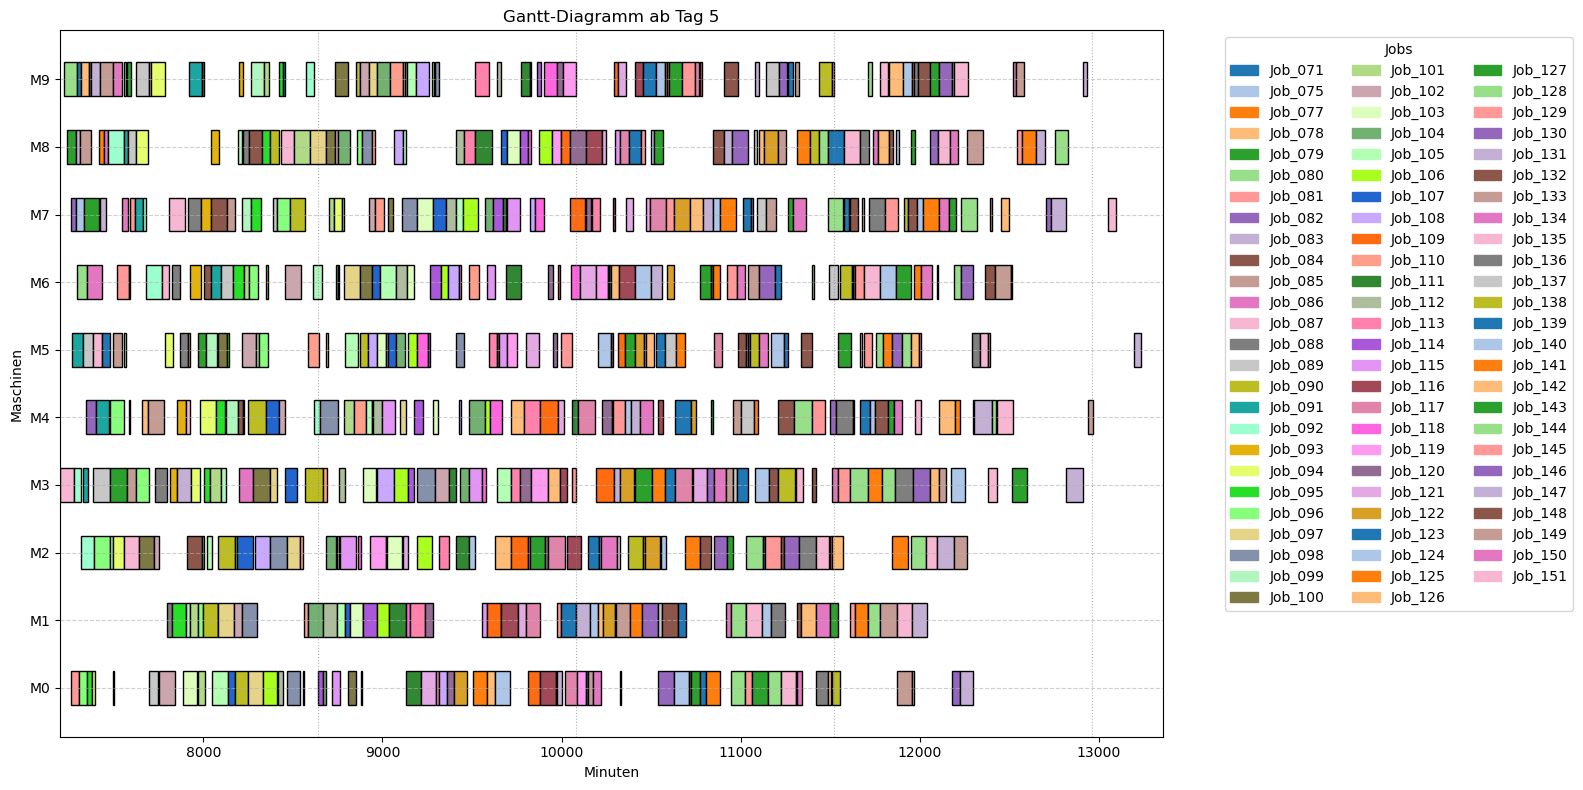

+ Keine Maschinenkonflikte gefunden
+ Für alle Jobs ist die Operationssequenz korrekt.
+ Zeitliche technologische Reihenfolge korrekt.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.

label
<-180           0
-180 - -120     0
-120 - -60      0
-60 - 0         4
0              72
0 - 60          0
60 - 120        0
120 - 180       1
>180            0
Name: count, dtype: int32
[120:00:00] Job_087 started on M3
[120:23:00] Job_080 started on M9
[120:39:00] Job_079 started on M8
[120:45:04] Job_087 finished on M3 (after 45 minutes 04 seconds)
[120:59:00] Job_082 started on M7
[121:00:00] Job_081 started on M0
[121:08:00] Job_091 started on M5
[121:16:00] Job_092 started on M3
[121:17:26] Job_080 finished on M9 (after 54 minutes 27 seconds)
[121:23:12] Job_082 finished on M7 (after 24 minutes 13 seconds)
[121:29:00] Job_075 started on M7
[121:32:17] Job_081 finished on M0 (after 32 minutes 17 seconds)
[121:33:00] Job_079 finished on M8 (after 54 minu

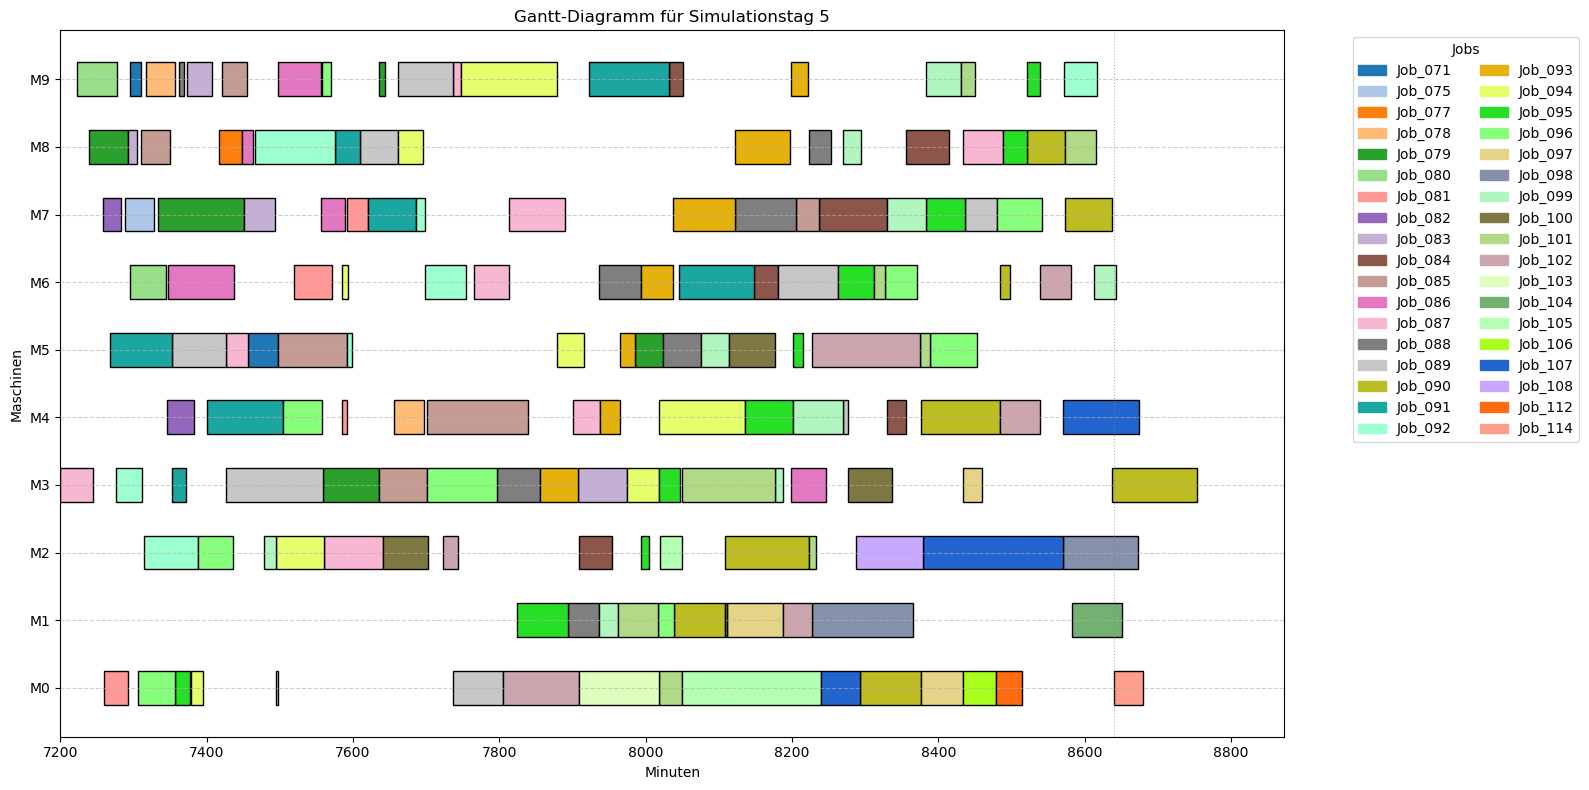


Solver-Status         : OPTIMAL
Objective Value       : 430.00
Best Objective Bound  : 430.00
Laufzeit              : 30.35 Sekunden

  Scheduling-Dauer: 0 Minuten und 30.68 Sekunden.


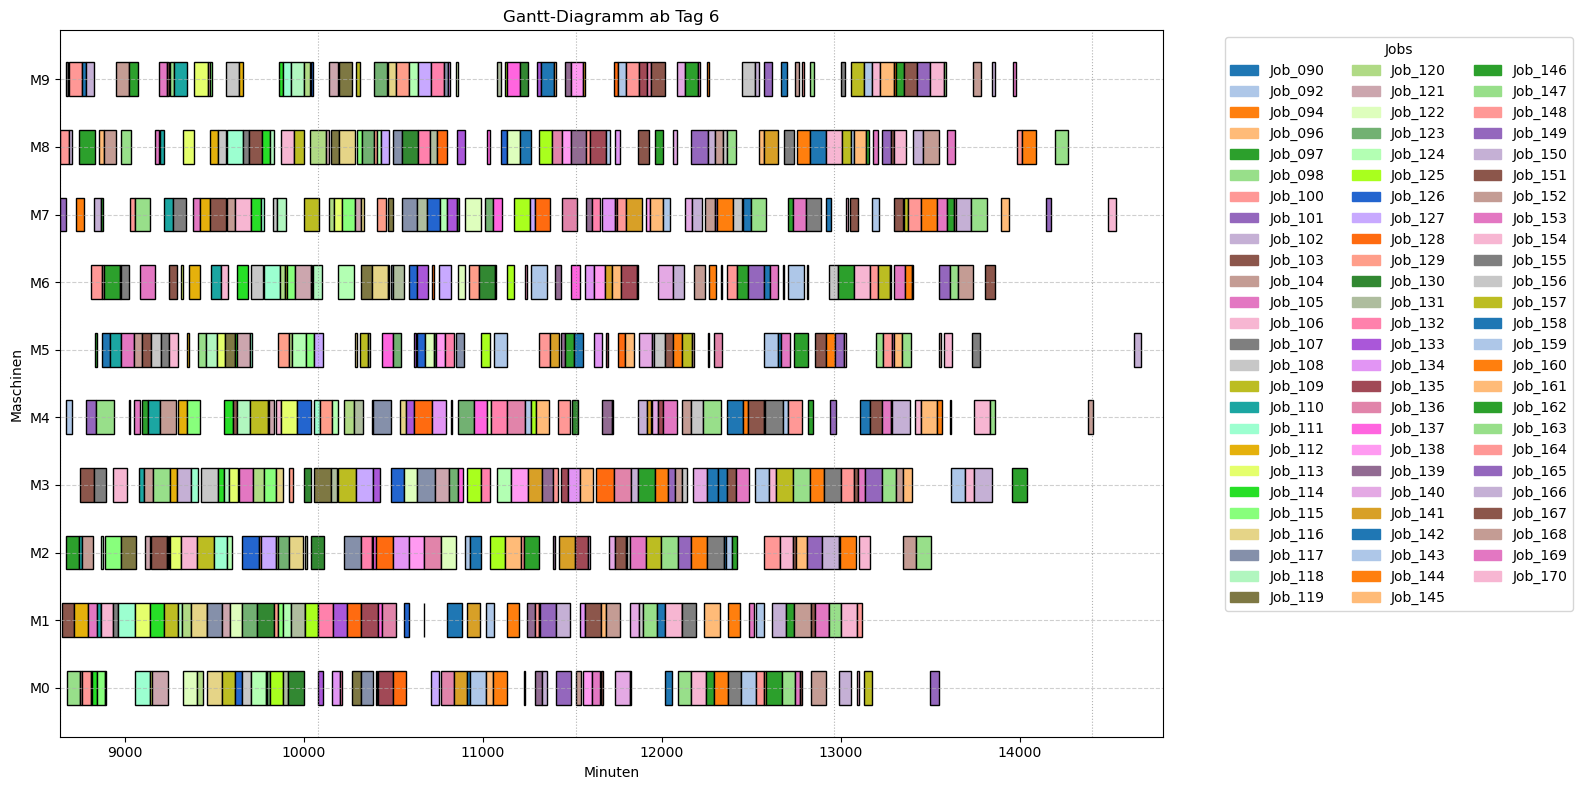

+ Keine Maschinenkonflikte gefunden
+ Für alle Jobs ist die Operationssequenz korrekt.
+ Zeitliche technologische Reihenfolge korrekt.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.

label
<-180           0
-180 - -120     0
-120 - -60      0
-60 - 0         4
0              72
0 - 60          1
60 - 120        0
120 - 180       0
>180            0
Name: count, dtype: int32
[144:00:00] Job_100 started on M8
[144:00:00] Job_101 started on M7
[144:11:00] Job_103 started on M1
[144:27:57] Job_101 finished on M7 (after 27 minutes 58 seconds)
[144:33:00] Job_097 started on M2
[144:35:00] Job_092 started on M4
[144:35:00] Job_107 started on M9
[144:35:12] Job_100 finished on M8 (after 35 minutes 12 seconds)
[144:40:00] Job_098 started on M0
[144:43:24] Job_107 finished on M9 (after 08 minutes 25 seconds)
[144:48:00] Job_102 started on M8
[144:48:00] Job_100 started on M9
[145:06:16] Job_102 finished on M8 (after 18 minutes 17 seconds)
[145:12:19] Job

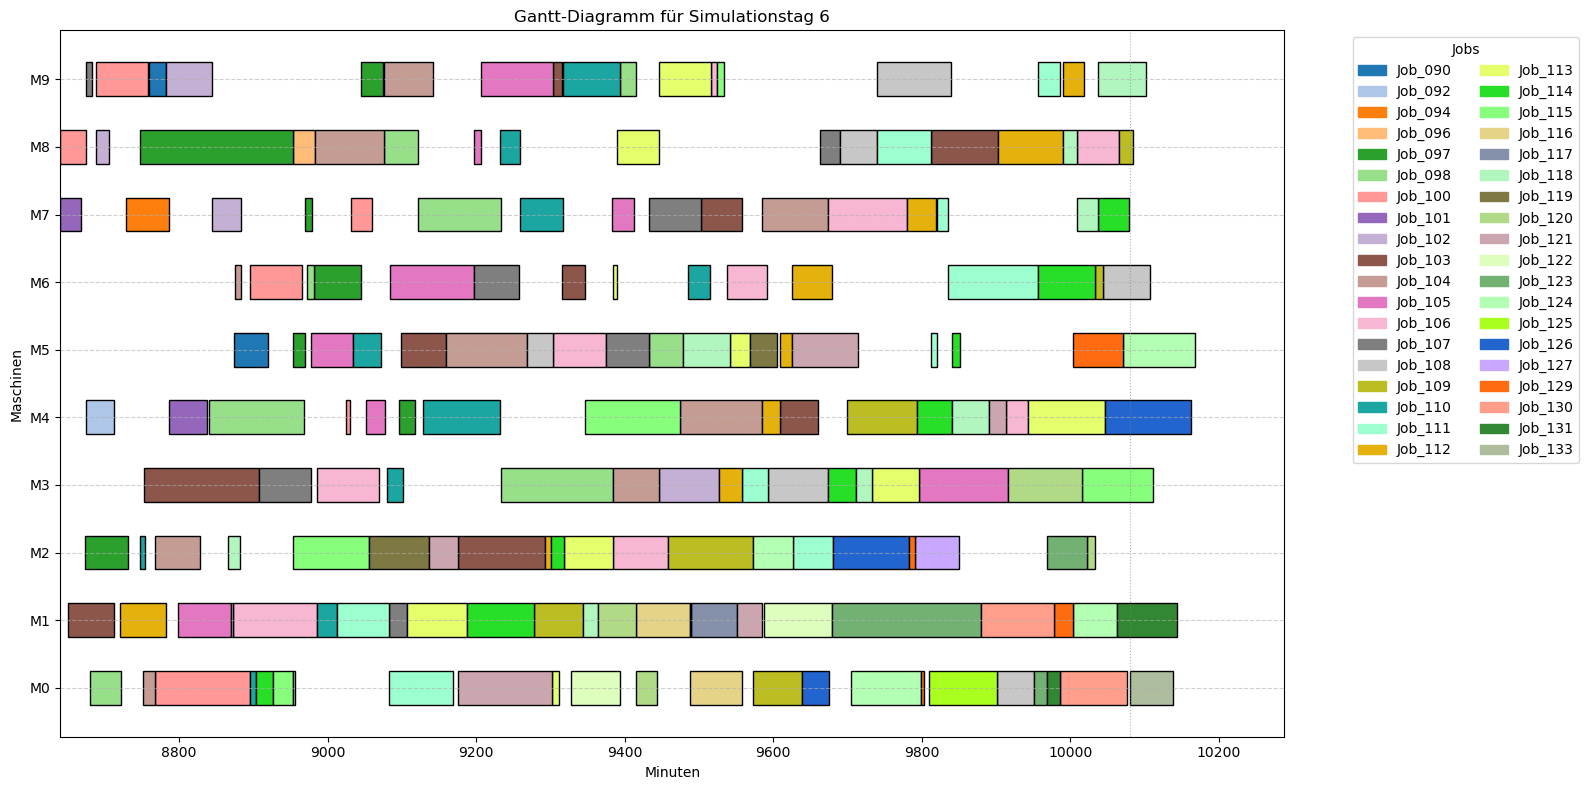


Solver-Status         : OPTIMAL
Objective Value       : 6038.00
Best Objective Bound  : 6038.00
Laufzeit              : 85.36 Sekunden

  Scheduling-Dauer: 1 Minuten und 25.59 Sekunden.


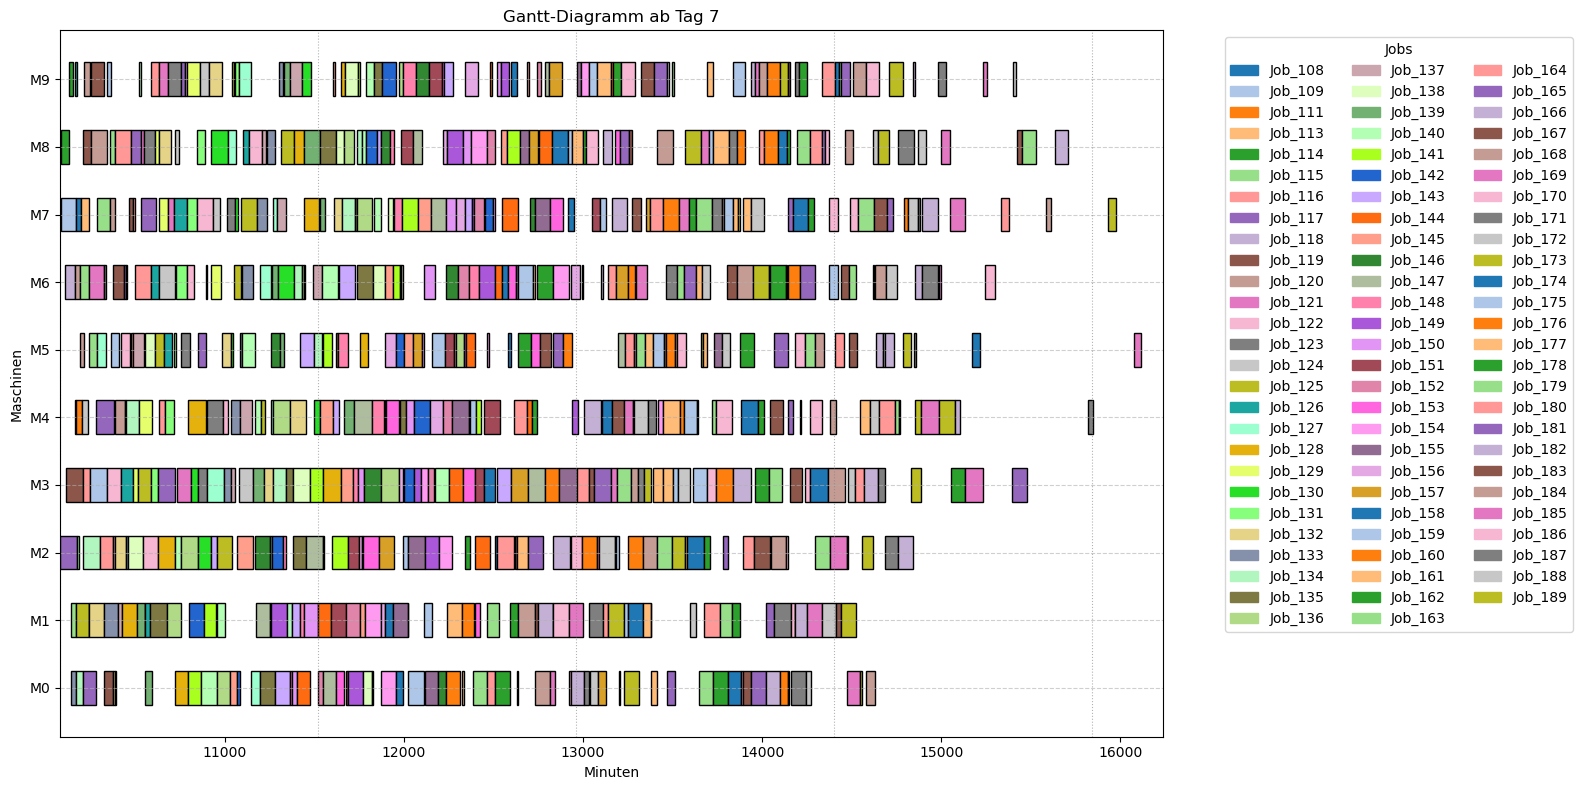

+ Keine Maschinenkonflikte gefunden
+ Für alle Jobs ist die Operationssequenz korrekt.
+ Zeitliche technologische Reihenfolge korrekt.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.

label
<-180           0
-180 - -120     0
-120 - -60      0
-60 - 0         6
0              65
0 - 60          3
60 - 120        3
120 - 180       1
>180            2
Name: count, dtype: int32
[168:00:00] Job_117 started on M2
[168:05:00] Job_109 started on M7
[168:05:00] Job_114 started on M8
[168:28:00] Job_118 started on M6
[168:31:00] Job_119 started on M3
[168:58:00] Job_133 started on M0
[168:59:22] Job_114 finished on M8 (after 54 minutes 22 seconds)
[168:59:22] Job_114 started on M9
[169:03:00] Job_115 started on M1
[169:04:58] Job_118 finished on M6 (after 36 minutes 58 seconds)
[169:18:07] Job_109 finished on M7 (after 73 minutes 08 seconds)
[169:21:00] Job_120 started on M6
[169:23:00] Job_108 started on M4
[169:23:16] Job_115 finished on M1 (after 20 m

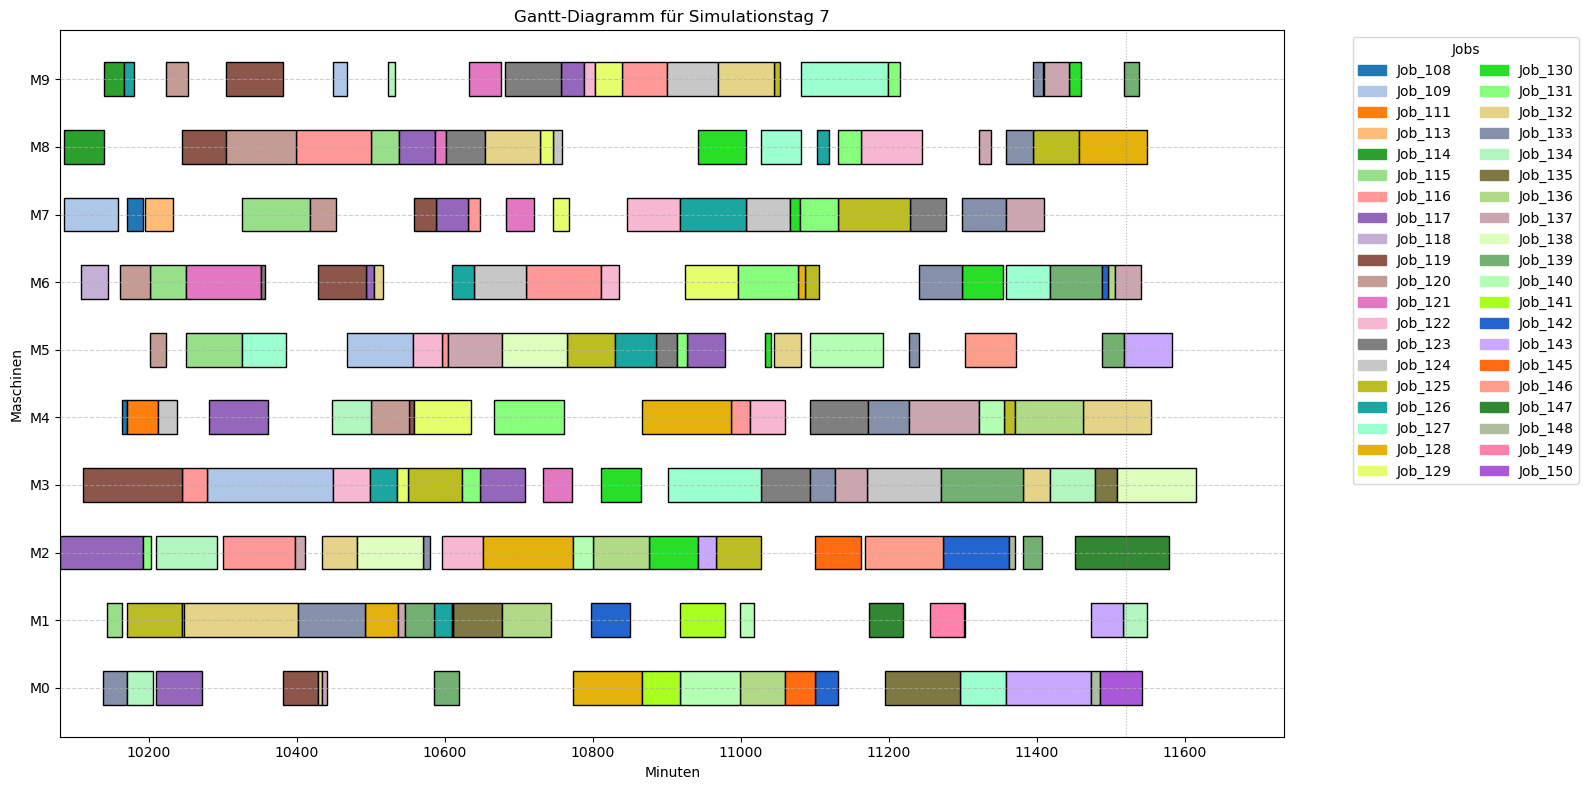

In [28]:
prefix_name = "06_simple"

first_start = 1
last_planning_start = 7

df_plan = df_plan_init
df_execution = df_execution_init

for day_numb in range(first_start, last_planning_start + 1):
    day_start = day_length * day_numb
    day_end = day_start + day_length
    planning_end = day_start + horizon_days * day_length

    # ------------------- I. Ankunfts- und Operationsvorbereitung -------------------
    df_jssp_curr, df_times_curr = rp_proced.filter_jobs_by_arrival_window(df_times, df_jssp, day_start, planning_end)
    df_jssp_curr = rp_proced.extend_with_undone_operations(df_jssp_curr, df_undone)
    df_times_curr = rp_proced.update_times_after_operation_changes(df_times, df_jssp_curr)

    # ------------------- II. Relevante laufende Operationen -------------------------
    df_execution_important = rp_proced.get_operations_running_into_day(df_execution, day_start)

    # ------------------- III. Rescheduling durchführen -------------------------------

    starting_time = time.time()
    df_plan = rssv.solve_cp_jssp_lateness_by_tardiness_and_earliness_with_fixed_ops(df_jssp_curr, df_times_curr, df_execution_important,
                                                                                    w_t = 5, reschedule_start = day_start, 
                                                                                    msg=False, timeLimit=max_time, gapRel= 0)

    
    solver_duration = time.time() - starting_time
    print(f"\n  Scheduling-Dauer: {int(solver_duration // 60)} Minuten und {(solver_duration % 60):.2f} Sekunden.")

    df_plan.to_csv(get_schedule_filename(prefix_name, day=day_numb), index=False)

    show.plot_gantt_machines(df_plan, title=f"Gantt-Diagramm ab Tag {day_numb}")
    check.check_constraints(df_plan)

    last_ops = df_plan.sort_values(['Job', 'Operation']).drop_duplicates('Job', keep='last')
    print(show.count_column_grouped(last_ops, "Lateness", max_val = 180, steps= 60))

    # ------------------- IV. Einen Tag simulieren -------------------------------------

    simulation = ProductionDaySimulation(df_plan, vc=0.35)
    df_execution, df_undone = simulation.run(start_time=day_start, end_time=day_end)
    if not df_execution.empty:
        show.plot_gantt_machines(df_execution, title=f"Gantt-Diagramm für Simulationstag {day_numb}", duration_column="Simulated Processing Time")
    else:
        print(f"Nothing executed on day {day_numb}")

## B) Rolling Planning mit "Deviation Penalty"

**Zielfunktion:**

Minimiere die gewichtete Summe aus Tardiness, Earliness und Abweichung vom ursprünglichen Startzeitpunkt (Deviation):

\\[
Z(\sigma) = r \cdot \sum_{j} \left( w_t \cdot \text{Tardiness}_j + w_e \cdot \text{Earliness}_j \right) + (1 - r) \cdot \sum_{j,o} \left| S_{jo} - S_{jo}^{\text{original}} \right|
\\]

wobei:

- \\( r \in [0,\ 1] \\): Gewichtung zwischen Termintreue und Planstabilität  
- \\( w_t \in \mathbb{N},\ w_e \in \mathbb{N} \\): Gewicht für Tardiness und Earliness  
- \\( \text{Tardiness}_j = \max(0, C_j - d_j) \\), \\( \text{Earliness}_j = \max(0, d_j - C_j) \\)  
    - \\( C_j \\) ist das Fertigstellungsdatum des letzten Schritts von Job \\( j \\)  
    - \\( d_j \\) ist die Deadline für Job \\( j \\)  
- \\( S_{jo} \\) ist der Startzeitpunkt der \\( o \\)-ten Operation von Job \\( j \\)  
- \\( S_{jo}^{\text{original}} \\) ist der ursprünglich geplante Startzeitpunkt

In [33]:
from ortools.sat.python import cp_model
import pandas as pd
import math

def solve_cp_jssp_lateness_by_tardiness_and_earliness_with_devpen(
    df_jssp: pd.DataFrame,
    df_arrivals_deadlines: pd.DataFrame,
    df_executed: pd.DataFrame,
    df_original_plan: pd.DataFrame,
    w_t: int = 5,
    w_e: int = 1,
    r: float = 0.5,
    reschedule_start: float = 1440.0,
    sort_ascending: bool = False,
    msg: bool = False,
    timeLimit: int = 3600,
    gapRel: float = 0.0
) -> pd.DataFrame:
    """
    Solves a Job-Shop Scheduling Problem using Constraint Programming with:
    - weighted tardiness,
    - earliness,
    - deviation penalty from a given reference plan (df_original_plan).

    Only deviations for operations present in both df_jssp and df_original_plan are considered.

    Parameters:
        df_jssp: Job-Shop structure with ['Job','Operation','Machine','Processing Time']
        df_arrivals_deadlines: Arrival and Deadline info per Job
        df_executed: Already executed operations
        df_original_plan: Reference plan with original start times
        w_t, w_e: Weights for tardiness and earliness
        r: Relative weight between lateness and deviation (0–1)
        reschedule_start: Planning starts from this time onward
        sort_ascending: Sort jobs by deadline ascending (default: False)
        msg: Verbose solver output
        timeLimit: Max solver time in seconds
        gapRel: Relative gap limit

    Returns:
        df_schedule: A DataFrame with scheduled operations and timing info
    """

    model = cp_model.CpModel()
    w_t = int(w_t)
    w_e = int(w_e)
    r_scaled = int(round(r * 100))  # scaled for integer arithmetic

    # === Vorbereitung: Ankunft, Deadline, Jobliste ===
    df_arrivals_deadlines = df_arrivals_deadlines.sort_values("Deadline", ascending=sort_ascending).reset_index(drop=True)
    arrival = df_arrivals_deadlines.set_index("Job")["Arrival"].to_dict()
    deadline = df_arrivals_deadlines.set_index("Job")["Deadline"].to_dict()
    jobs = df_arrivals_deadlines["Job"].tolist()

    # === Relevante Deviation-Paare bestimmen ===
    deviation_relevant_ops = set(
        df_jssp[["Job", "Operation"]].apply(tuple, axis=1)
    ) & set(
        df_original_plan[["Job", "Operation"]].apply(tuple, axis=1)
    )

    original_start = {
        (row["Job"], row["Operation"]): int(round(row["Start"]))
        for _, row in df_original_plan.iterrows()
        if (row["Job"], row["Operation"]) in deviation_relevant_ops
    }

    # === Operationen strukturieren ===
    ops_grouped = df_jssp.sort_values(["Job", "Operation"]).groupby("Job")
    all_ops, machines = [], set()
    for job in jobs:
        seq = []
        for _, row in ops_grouped.get_group(job).iterrows():
            op_id = int(row["Operation"])
            m = str(row["Machine"])
            d = int(round(row["Processing Time"]))
            seq.append((op_id, m, d))
            machines.add(m)
        all_ops.append(seq)

    # === Planungshorizont abschätzen ===
    horizon = int(df_jssp["Processing Time"].sum() + max(deadline.values()))

    # === Fixierte Operationen berücksichtigen ===
    df_executed_fixed = df_executed[df_executed["End"] >= reschedule_start]
    fixed_ops = {
        m: list(grp[["Start", "End"]].itertuples(index=False, name=None))
        for m, grp in df_executed_fixed.groupby("Machine")
    }
    last_executed_end = df_executed.groupby("Job")["End"].max().to_dict()

    # === Variablen definieren ===
    starts, ends, intervals = {}, {}, {}
    weighted_terms = []
    deviation_terms = []

    for j, job in enumerate(jobs):
        for o, (op_id, m, d) in enumerate(all_ops[j]):
            suffix = f"{j}_{o}"
            start = model.NewIntVar(0, horizon, f"start_{suffix}")
            end = model.NewIntVar(0, horizon, f"end_{suffix}")
            interval = model.NewIntervalVar(start, d, end, f"interval_{suffix}")
            starts[(j, o)] = start
            ends[(j, o)] = end
            intervals[(j, o)] = (interval, m)

    # === Constraints und Zielterme ===
    for j, job in enumerate(jobs):
        last_op_index = len(all_ops[j]) - 1
        job_end = ends[(j, last_op_index)]

        # Lateness = End - Deadline
        lateness = model.NewIntVar(-horizon, horizon, f"lateness_{j}")
        model.Add(lateness == job_end - deadline[job])

        # Tardiness
        tardiness = model.NewIntVar(0, horizon, f"tardiness_{j}")
        model.AddMaxEquality(tardiness, [lateness, 0])
        term_tardiness = model.NewIntVar(0, horizon * w_t, f"term_tardiness_{j}")
        model.Add(term_tardiness == w_t * tardiness)
        weighted_terms.append(term_tardiness)

        # Earliness
        earliness = model.NewIntVar(0, horizon, f"earliness_{j}")
        model.AddMaxEquality(earliness, [-lateness, 0])
        term_earliness = model.NewIntVar(0, horizon * w_e, f"term_earliness_{j}")
        model.Add(term_earliness == w_e * earliness)
        weighted_terms.append(term_earliness)

        # Startzeitbedingungen
        model.Add(starts[(j, 0)] >= max(arrival[job], int(reschedule_start)))
        if job in last_executed_end:
            model.Add(starts[(j, 0)] >= int(math.ceil(last_executed_end[job])))

        # Technologische Reihenfolge
        for o in range(1, len(all_ops[j])):
            model.Add(starts[(j, o)] >= ends[(j, o - 1)])

        # Deviation: nur für relevante Ops
        for o, (op_id, _, _) in enumerate(all_ops[j]):
            key = (job, op_id)
            if key in original_start:
                dev = model.NewIntVar(0, horizon, f"dev_{j}_{o}")
                diff = model.NewIntVar(-horizon, horizon, f"diff_{j}_{o}")
                model.Add(diff == starts[(j, o)] - original_start[key])
                model.AddAbsEquality(dev, diff)
                deviation_terms.append(dev)

    # === Maschinenrestriktionen (inkl. fixierter Intervalle) ===
    for m in machines:
        machine_intervals = [interval for (j, o), (interval, mach) in intervals.items() if mach == m]
        for fixed_start, fixed_end in fixed_ops.get(m, []):
            start = math.floor(fixed_start)
            end = math.ceil(fixed_end)
            duration = end - start
            if duration > 0:
                fixed_interval = model.NewIntervalVar(start, duration, end, f"fixed_{m}_{end}")
                machine_intervals.append(fixed_interval)
        model.AddNoOverlap(machine_intervals)

    # === Zielfunktion kombinieren ===
    weighted_part = model.NewIntVar(0, horizon * len(weighted_terms), "weighted_part")
    deviation_part = model.NewIntVar(0, horizon * len(deviation_terms), "deviation_part")
    model.Add(weighted_part == sum(weighted_terms))
    model.Add(deviation_part == sum(deviation_terms))

    total_cost = model.NewIntVar(0, horizon * len(jobs) * 100, "total_cost")
    model.Add(total_cost == r_scaled * weighted_part + (100 - r_scaled) * deviation_part)
    model.Minimize(total_cost)

    # === Solver-Einstellungen ===
    solver = cp_model.CpSolver()
    solver.parameters.log_search_progress = msg
    solver.parameters.max_time_in_seconds = timeLimit
    solver.parameters.relative_gap_limit = gapRel
    status = solver.Solve(model)

    # === Ergebnis extrahieren ===
    records = []
    if status in [cp_model.OPTIMAL, cp_model.FEASIBLE]:
        for j, job in enumerate(jobs):
            for o, (op_id, m, d) in enumerate(all_ops[j]):
                st = solver.Value(starts[(j, o)])
                ed = st + d
                lateness_val = ed - deadline[job]
                records.append({
                    "Job": job,
                    "Operation": op_id,
                    "Arrival": arrival[job],
                    "Deadline": deadline[job],
                    "Machine": m,
                    "Start": st,
                    "Processing Time": d,
                    "End": ed,
                    "Lateness": lateness_val,
                    "Tardiness": max(0, lateness_val),
                    "Earliness": max(0, -lateness_val)
                })

        df_schedule = pd.DataFrame.from_records(records).sort_values(["Start", "Job", "Operation"]).reset_index(drop=True)
    else:
        print(f"\nSolver-Status         : {solver.StatusName(status)}")
        print("No feasible solution found!")
        df_schedule = pd.DataFrame()

    # === Logging ===
    print(f"\nSolver-Status         : {solver.StatusName(status)}")
    print(f"Objective Value       : {solver.ObjectiveValue():.2f}")
    print(f"Best Objective Bound  : {solver.BestObjectiveBound():.2f}")
    print(f"Laufzeit              : {solver.WallTime():.2f} Sekunden")
    print(f"Deviation terms       : {len(deviation_terms)}")

    return df_schedule



Solver-Status         : OPTIMAL
Objective Value       : 14700.00
Best Objective Bound  : 14000.00
Laufzeit              : 45.79 Sekunden
Deviation terms       : 380

  Scheduling-Dauer: 0 Minuten und 46.18 Sekunden.


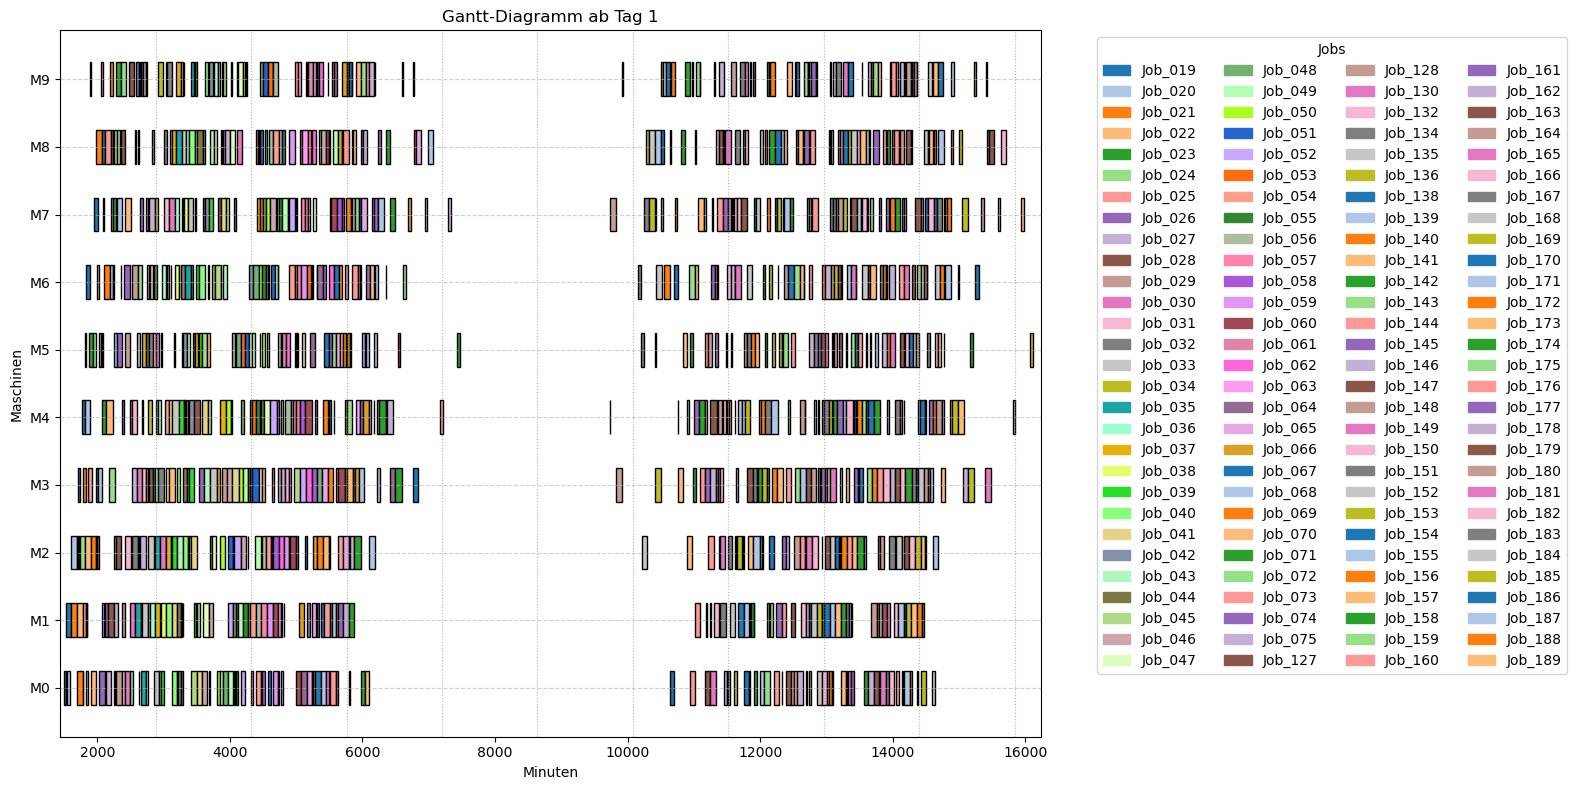

+ Keine Maschinenkonflikte gefunden
+ Für alle Jobs ist die Operationssequenz korrekt.
+ Zeitliche technologische Reihenfolge korrekt.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.

label
<-180            0
-180 - -120      0
-120 - -60       0
-60 - 0          6
0              110
0 - 60           0
60 - 120         0
120 - 180        0
>180             0
Name: count, dtype: int32
[25:03:00] Job_019 started on M0
[25:32:16] Job_019 finished on M0 (after 29 minutes 16 seconds)
[25:32:16] Job_019 started on M1
[25:45:00] Job_020 started on M0
[26:35:19] Job_019 finished on M1 (after 63 minutes 04 seconds)
[26:40:30] Job_020 finished on M0 (after 55 minutes 30 seconds)
[26:46:00] Job_020 started on M2
[26:50:00] Job_021 started on M1
[27:36:08] Job_021 finished on M1 (after 46 minutes 08 seconds)
[27:38:26] Job_020 finished on M2 (after 52 minutes 26 seconds)
[28:16:00] Job_019 started on M2
[28:21:00] Job_022 started on M1
[28:21:00] Job_021 st

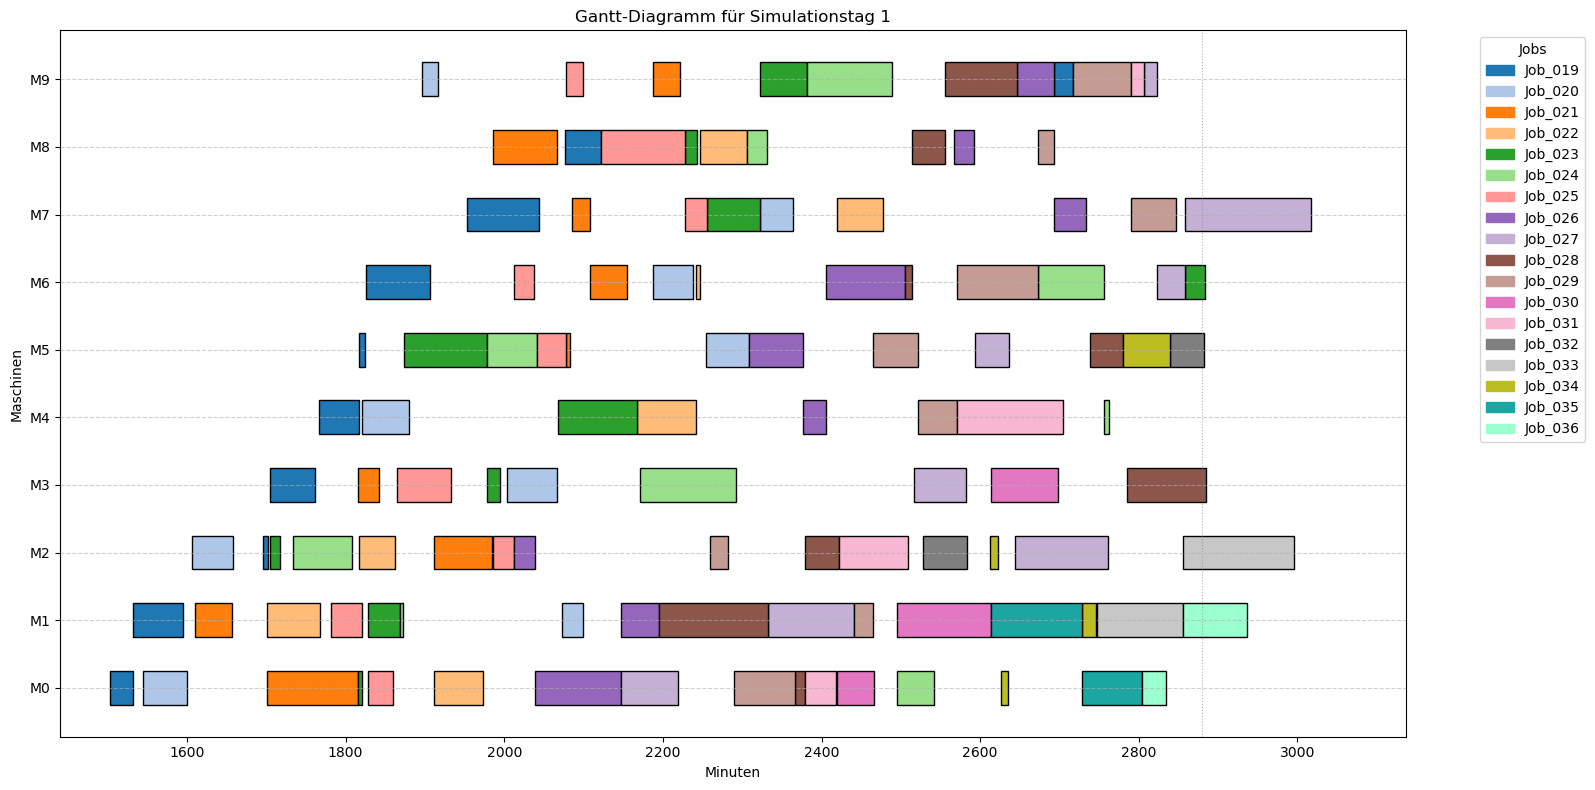


Solver-Status         : FEASIBLE
Objective Value       : 403540.00
Best Objective Bound  : 225390.00
Laufzeit              : 2701.37 Sekunden
Deviation terms       : 960

  Scheduling-Dauer: 45 Minuten und 2.05 Sekunden.


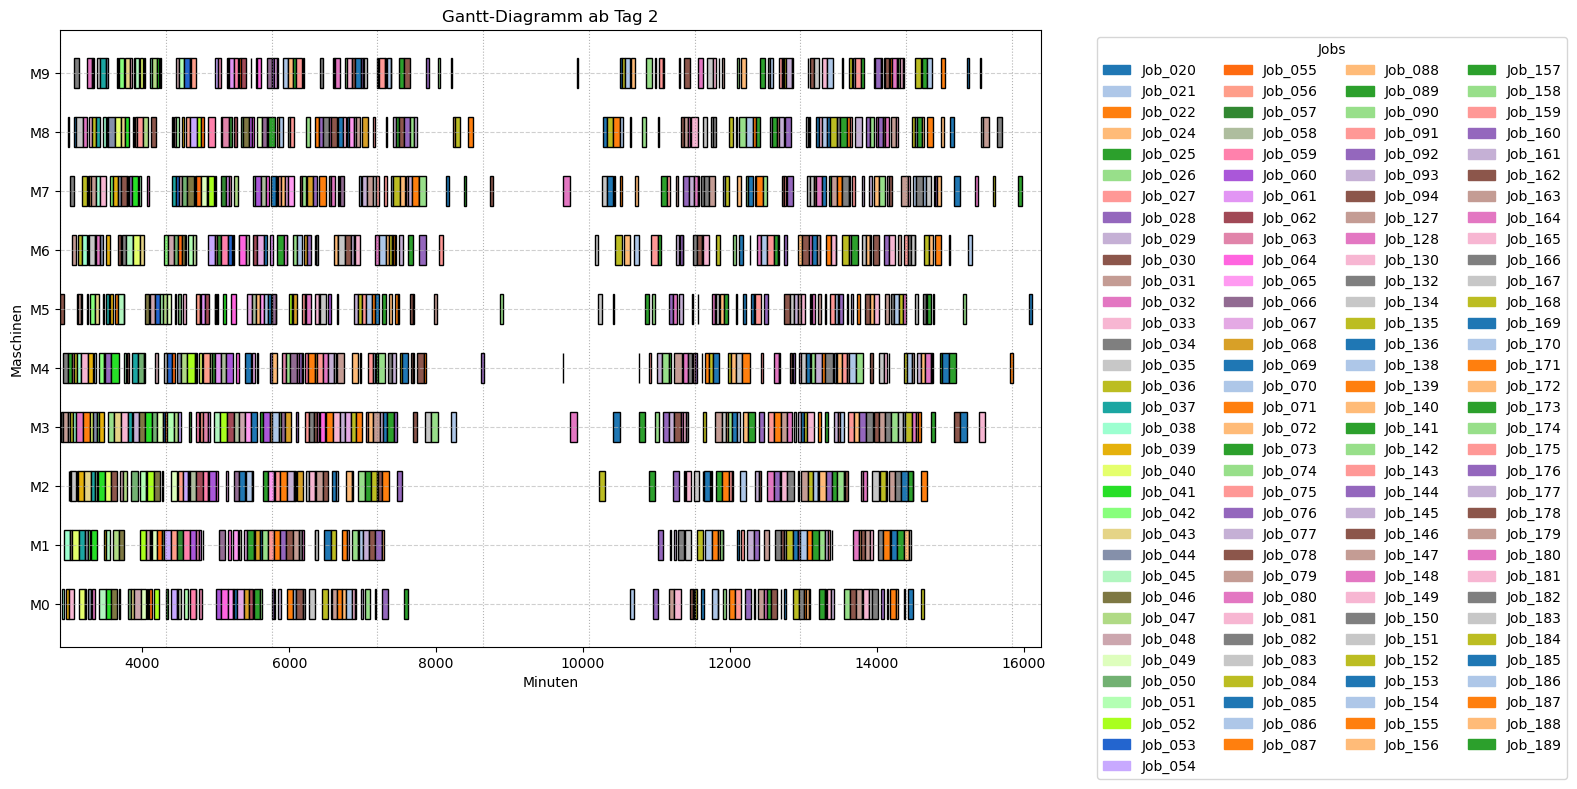

+ Keine Maschinenkonflikte gefunden
+ Für alle Jobs ist die Operationssequenz korrekt.
+ Zeitliche technologische Reihenfolge korrekt.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.

label
<-180            0
-180 - -120      0
-120 - -60       0
-60 - 0         10
0              123
0 - 60           0
60 - 120         0
120 - 180        0
>180             0
Name: count, dtype: int32
[48:03:00] Job_030 started on M5
[48:06:00] Job_034 started on M3
[48:19:55] Job_034 finished on M3 (after 13 minutes 55 seconds)
[48:28:00] Job_038 started on M0
[48:32:00] Job_031 started on M3
[48:32:00] Job_034 started on M4
[48:48:16] Job_038 finished on M0 (after 20 minutes 16 seconds)
[48:57:00] Job_038 started on M1
[49:06:45] Job_030 finished on M5 (after 63 minutes 46 seconds)
[49:17:50] Job_034 finished on M4 (after 45 minutes 51 seconds)
[49:20:00] Job_039 started on M0
[49:41:00] Job_025 started on M4
[49:41:00] Job_034 started on M8
[49:43:59] Job_031 

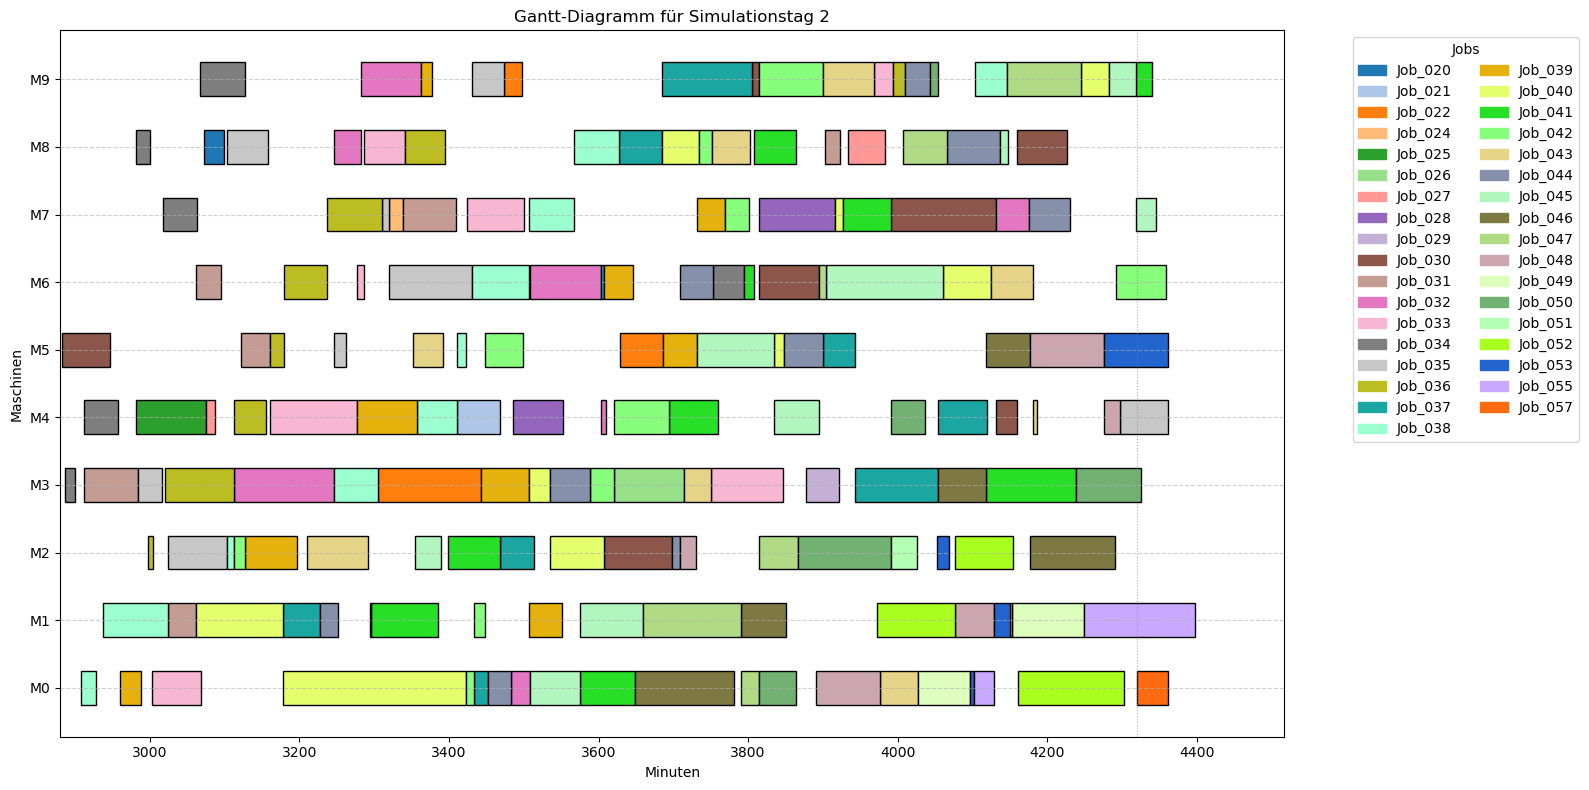


Solver-Status         : FEASIBLE
Objective Value       : 345720.00
Best Objective Bound  : 142300.00
Laufzeit              : 2701.12 Sekunden
Deviation terms       : 971

  Scheduling-Dauer: 45 Minuten und 2.28 Sekunden.


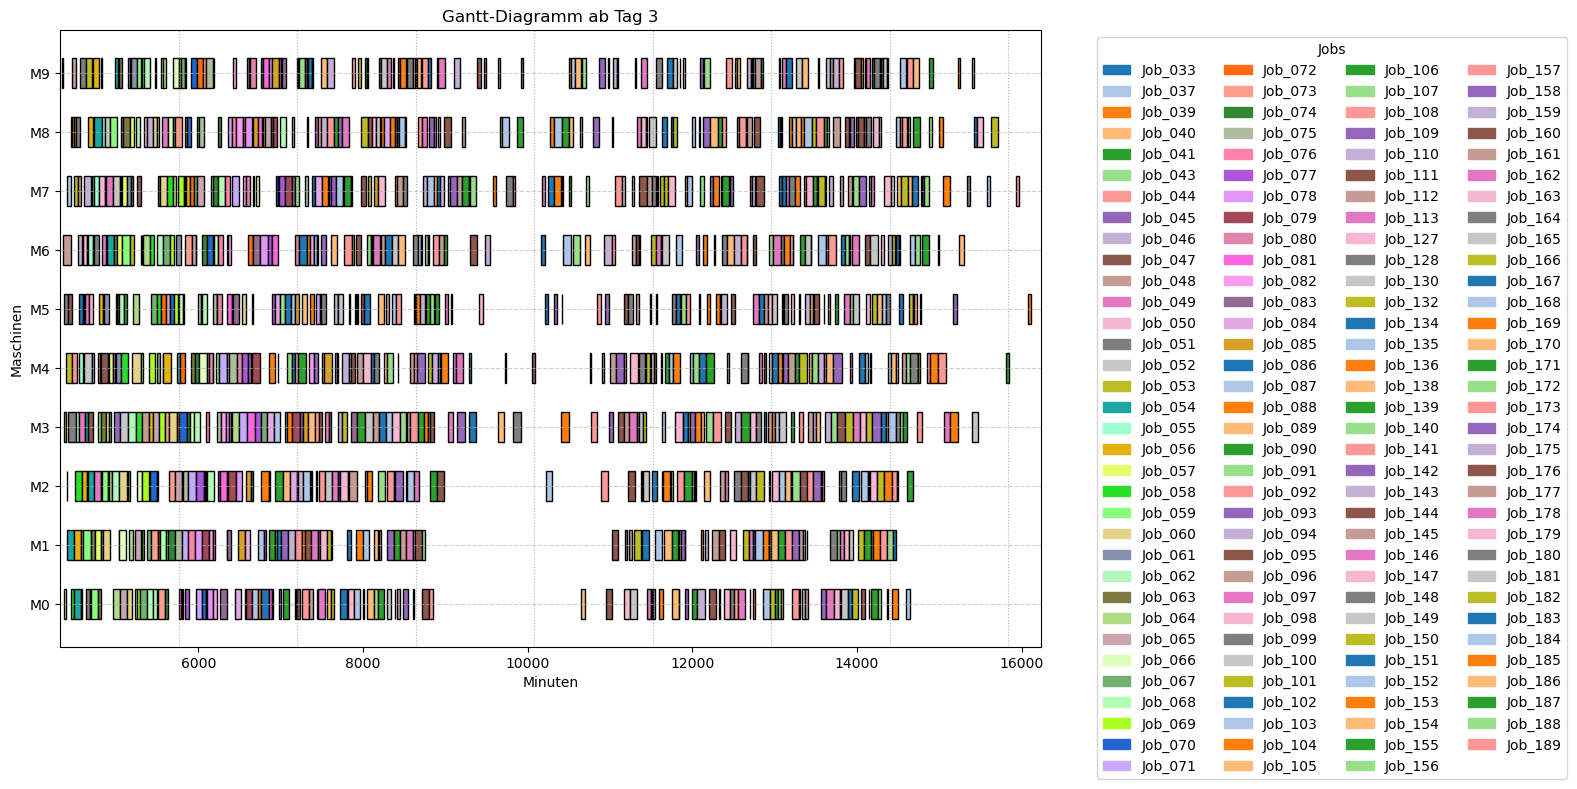

+ Keine Maschinenkonflikte gefunden
+ Für alle Jobs ist die Operationssequenz korrekt.
+ Zeitliche technologische Reihenfolge korrekt.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.

label
<-180            0
-180 - -120      0
-120 - -60       0
-60 - 0          8
0              127
0 - 60           0
60 - 120         0
120 - 180        0
>180             0
Name: count, dtype: int32
[72:21:00] Job_046 started on M9
[72:40:00] Job_048 started on M6
[72:41:30] Job_046 finished on M9 (after 20 minutes 31 seconds)
[72:42:00] Job_057 started on M0
[72:43:00] Job_051 started on M5
[72:43:00] Job_053 started on M3
[73:02:35] Job_057 finished on M0 (after 20 minutes 35 seconds)
[73:09:46] Job_053 finished on M3 (after 26 minutes 46 seconds)
[73:09:46] Job_053 started on M4
[73:18:00] Job_054 started on M1
[73:18:00] Job_055 started on M2
[73:19:46] Job_051 finished on M5 (after 36 minutes 46 seconds)
[73:26:40] Job_055 finished on M2 (after 08 minutes 

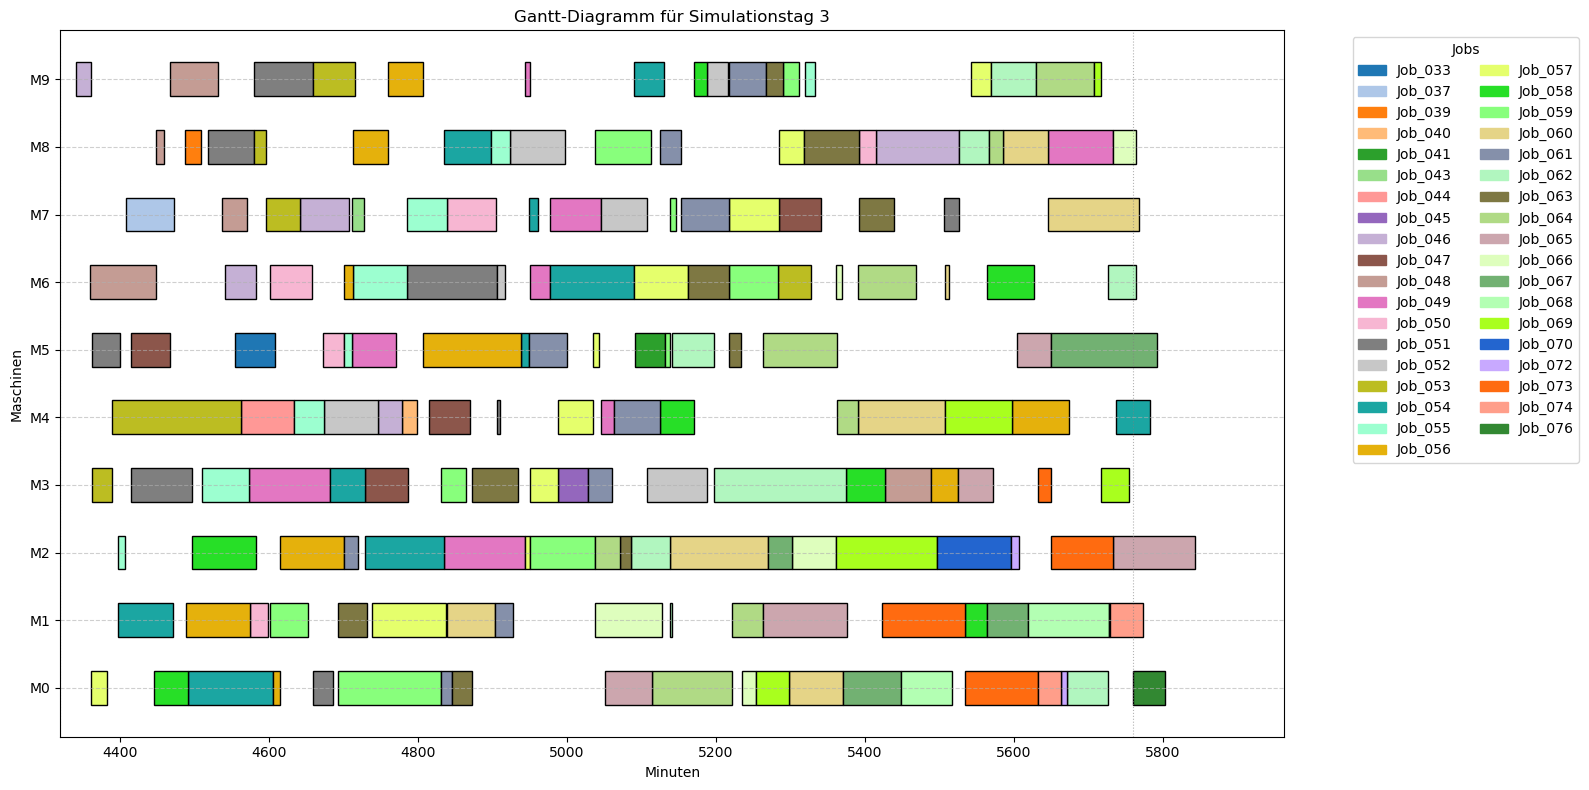


Solver-Status         : FEASIBLE
Objective Value       : 587080.00
Best Objective Bound  : 304330.00
Laufzeit              : 2701.38 Sekunden
Deviation terms       : 981

  Scheduling-Dauer: 45 Minuten und 2.50 Sekunden.


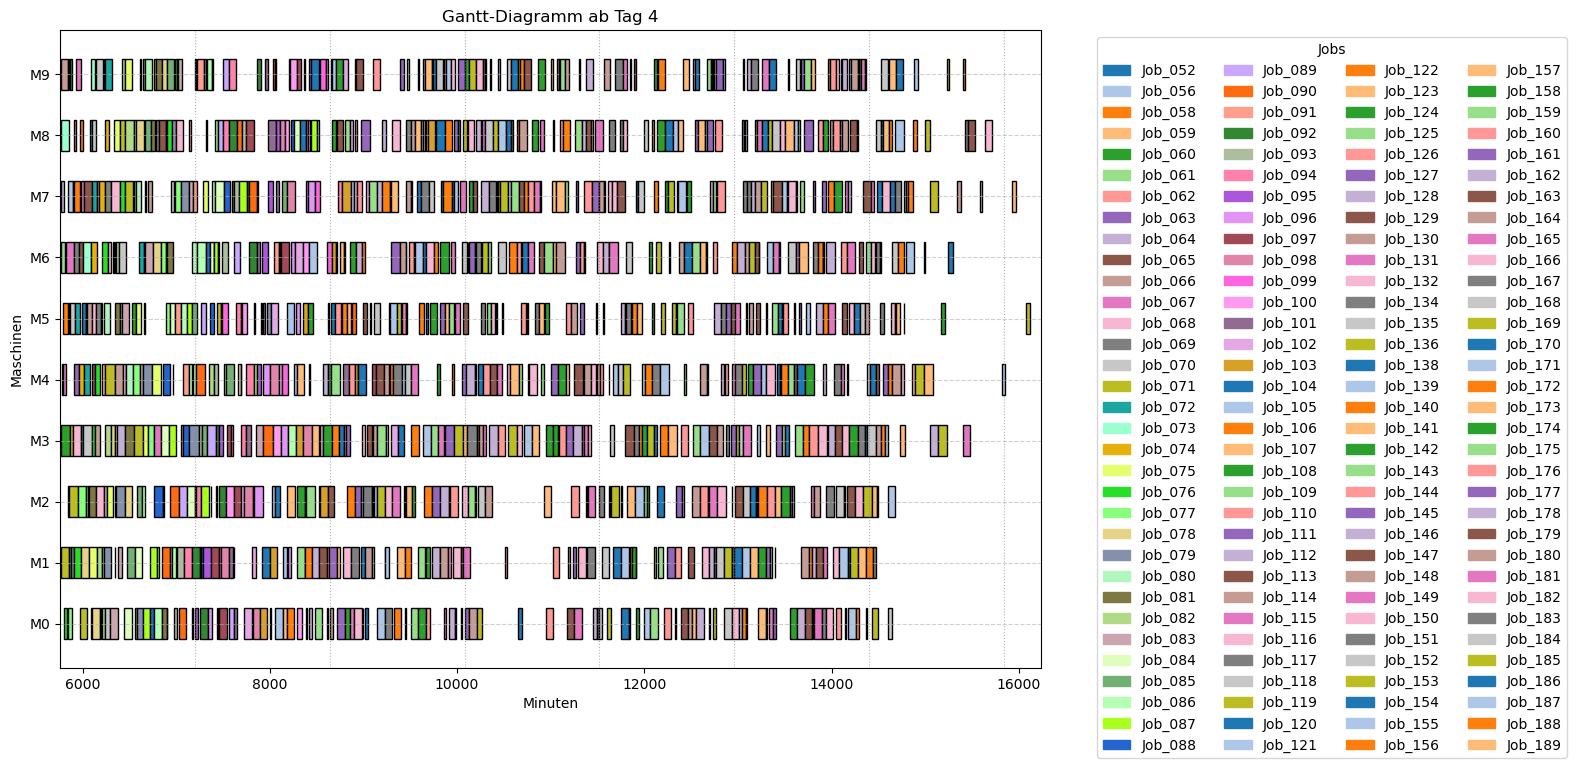

+ Keine Maschinenkonflikte gefunden
+ Für alle Jobs ist die Operationssequenz korrekt.
+ Zeitliche technologische Reihenfolge korrekt.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.

label
<-180            0
-180 - -120      1
-120 - -60       0
-60 - 0         17
0              110
0 - 60           4
60 - 120         0
120 - 180        0
>180             0
Name: count, dtype: int32
[96:04:00] Job_061 started on M6
[96:04:00] Job_066 started on M9
[96:04:00] Job_073 started on M8
[96:08:00] Job_060 started on M3
[96:08:00] Job_064 started on M7
[96:13:00] Job_071 started on M1
[96:24:00] Job_062 started on M4
[96:27:43] Job_062 finished on M4 (after 03 minutes 44 seconds)
[96:33:00] Job_058 started on M5
[96:33:00] Job_067 started on M4
[96:38:14] Job_064 finished on M7 (after 30 minutes 14 seconds)
[96:40:26] Job_061 finished on M6 (after 36 minutes 27 seconds)
[96:43:00] Job_076 started on M0
[97:00:11] Job_073 finished on M8 (after 56 minute

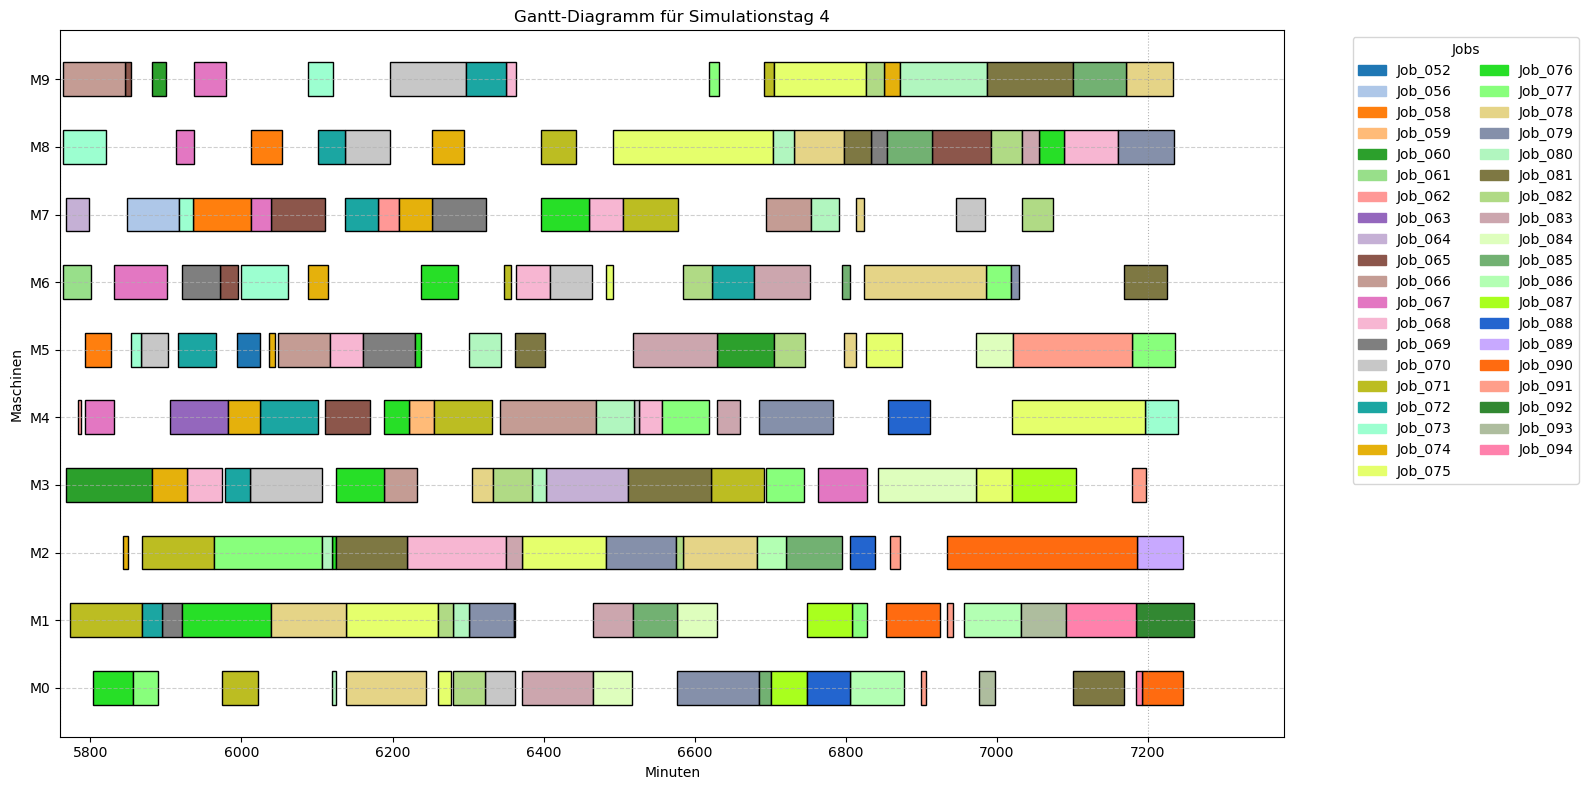


Solver-Status         : FEASIBLE
Objective Value       : 1571950.00
Best Objective Bound  : 773310.00
Laufzeit              : 2701.55 Sekunden
Deviation terms       : 973

  Scheduling-Dauer: 45 Minuten und 1.88 Sekunden.


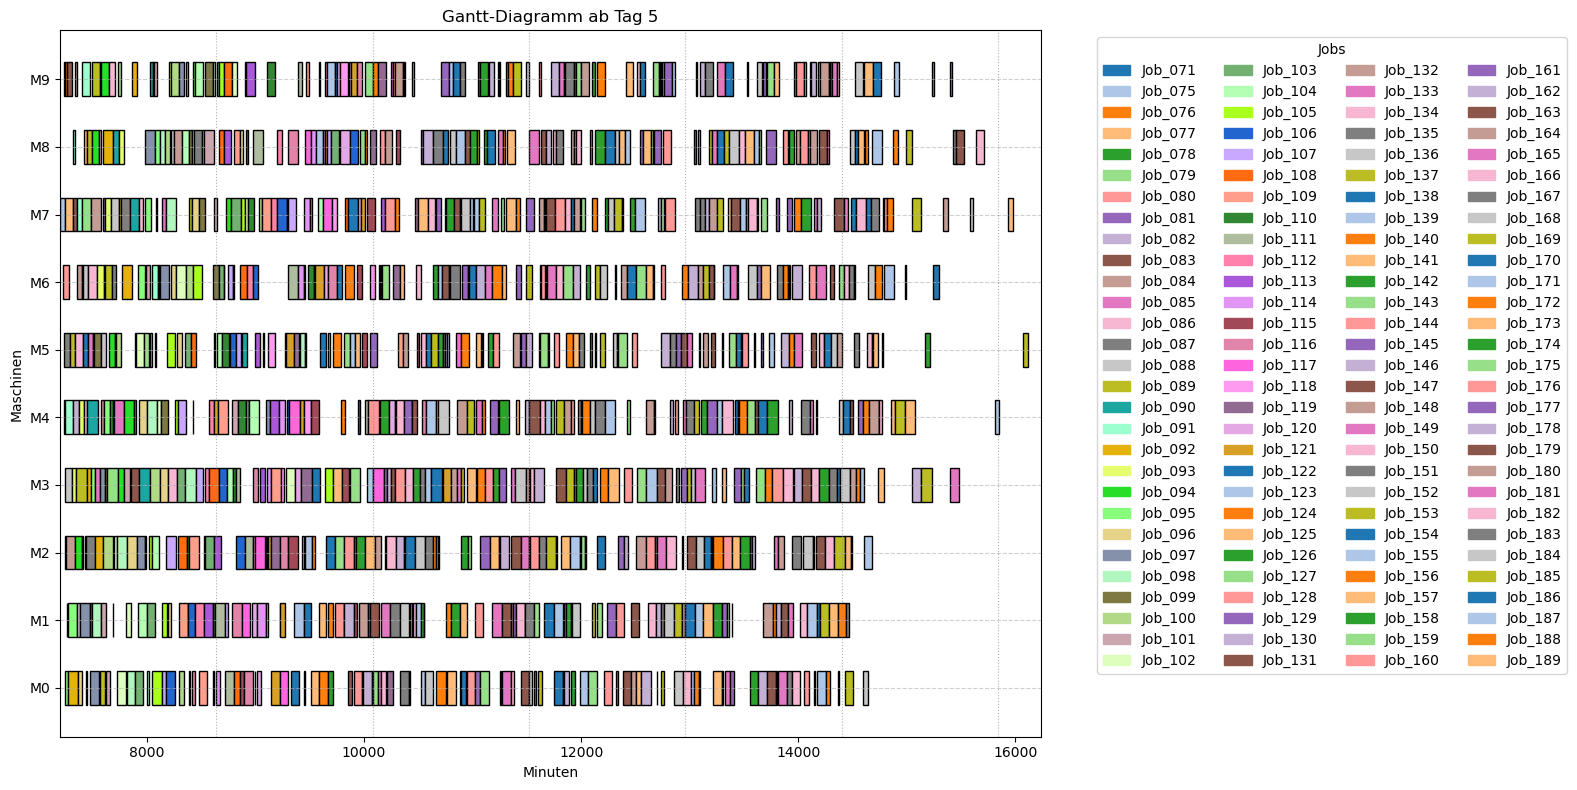

+ Keine Maschinenkonflikte gefunden
+ Für alle Jobs ist die Operationssequenz korrekt.
+ Zeitliche technologische Reihenfolge korrekt.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.

label
<-180           0
-180 - -120     0
-120 - -60      1
-60 - 0        17
0              96
0 - 60          1
60 - 120        0
120 - 180       0
>180            1
Name: count, dtype: int32
[120:00:00] Job_075 started on M7
[120:25:00] Job_080 started on M6
[120:29:16] Job_075 finished on M7 (after 29 minutes 17 seconds)
[120:33:00] Job_088 started on M9
[120:37:00] Job_087 started on M5
[120:40:00] Job_081 started on M4
[120:42:51] Job_088 finished on M9 (after 09 minutes 51 seconds)
[120:44:00] Job_076 started on M9
[120:44:00] Job_088 started on M3
[120:45:00] Job_077 started on M7
[120:47:00] Job_093 started on M2
[120:47:00] Job_095 started on M0
[120:48:33] Job_081 finished on M4 (after 08 minutes 33 seconds)
[120:48:33] Job_091 started on M4
[120:50:59] 

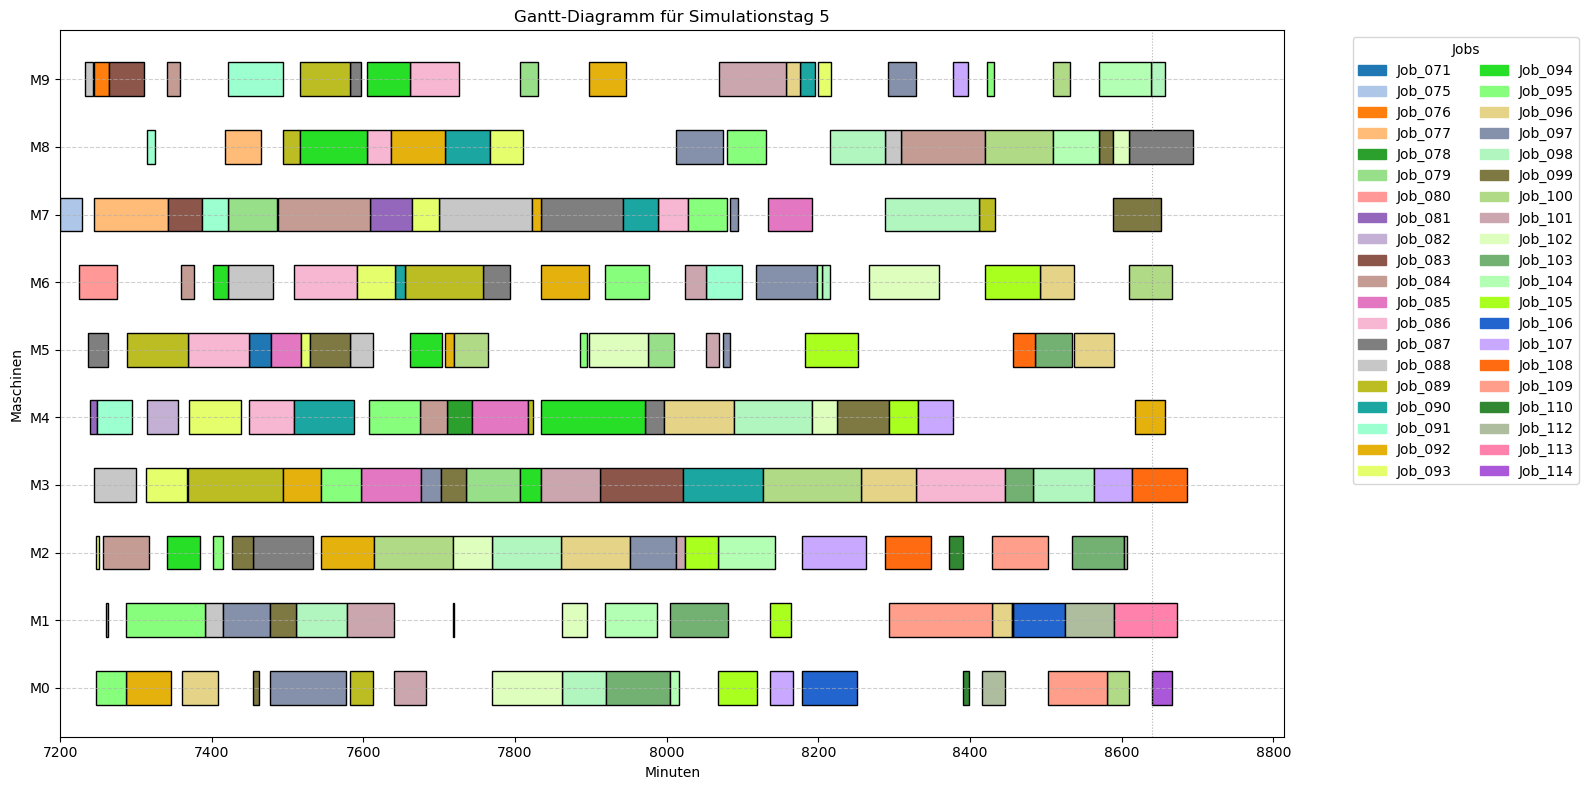


Solver-Status         : FEASIBLE
Objective Value       : 252730.00
Best Objective Bound  : 185970.00
Laufzeit              : 2700.99 Sekunden
Deviation terms       : 849

  Scheduling-Dauer: 45 Minuten und 1.90 Sekunden.


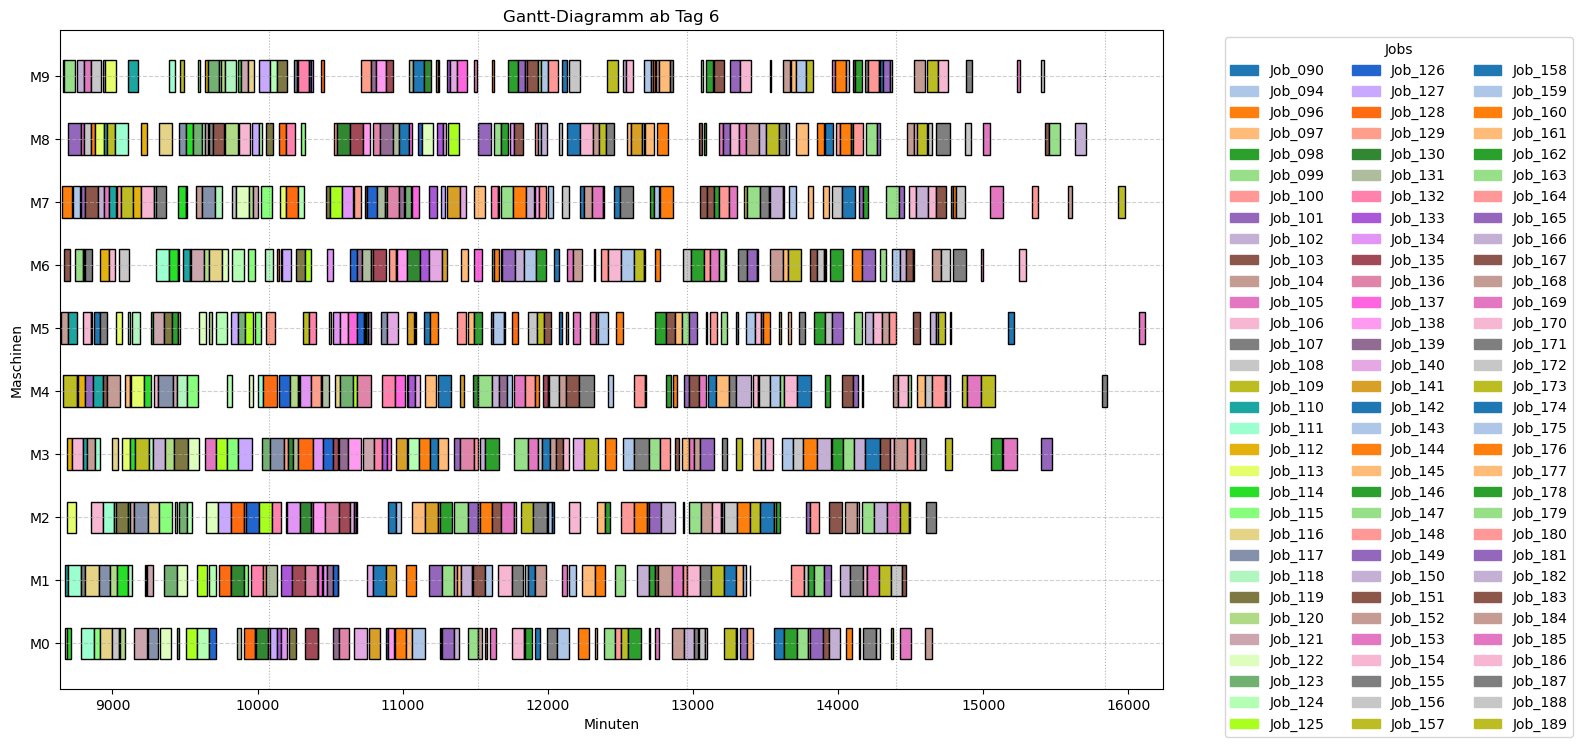

+ Keine Maschinenkonflikte gefunden
+ Für alle Jobs ist die Operationssequenz korrekt.
+ Zeitliche technologische Reihenfolge korrekt.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.

label
<-180           0
-180 - -120     0
-120 - -60      0
-60 - 0        16
0              78
0 - 60          1
60 - 120        0
120 - 180       1
>180            0
Name: count, dtype: int32
[144:08:00] Job_104 started on M5
[144:13:00] Job_096 started on M7
[144:17:00] Job_109 started on M4
[144:18:00] Job_103 started on M9
[144:28:36] Job_103 finished on M9 (after 10 minutes 36 seconds)
[144:29:00] Job_099 started on M9
[144:29:00] Job_103 started on M6
[144:33:00] Job_110 started on M1
[144:33:00] Job_113 started on M0
[144:45:19] Job_104 finished on M5 (after 37 minutes 20 seconds)
[144:47:00] Job_112 started on M3
[144:55:00] Job_101 started on M8
[144:56:36] Job_113 finished on M0 (after 23 minutes 36 seconds)
[144:56:36] Job_114 started on M0
[144:56:36] 

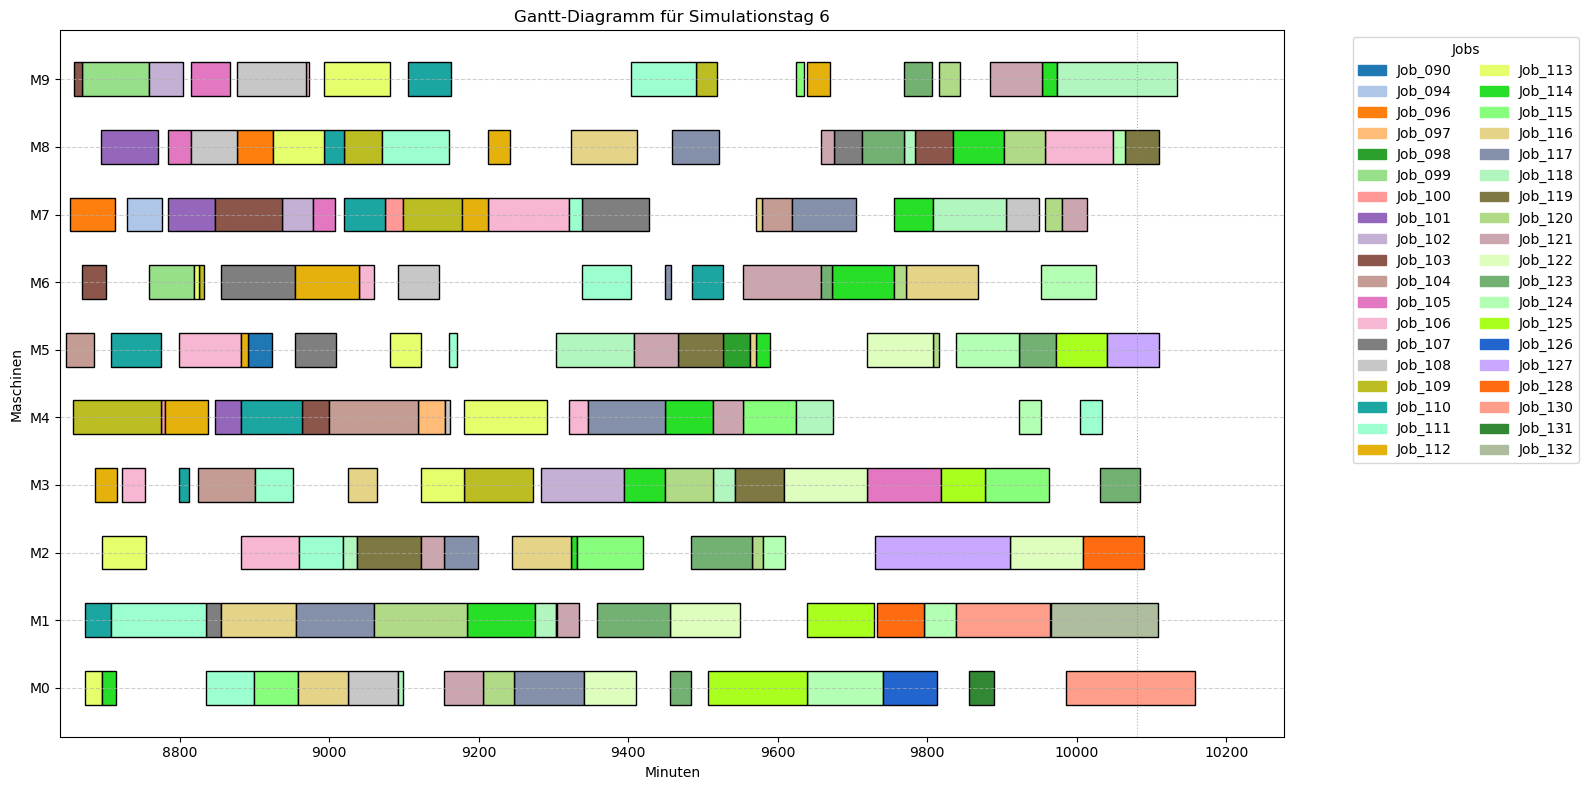


Solver-Status         : FEASIBLE
Objective Value       : 742410.00
Best Objective Bound  : 424020.00
Laufzeit              : 2701.14 Sekunden
Deviation terms       : 666

  Scheduling-Dauer: 45 Minuten und 1.87 Sekunden.


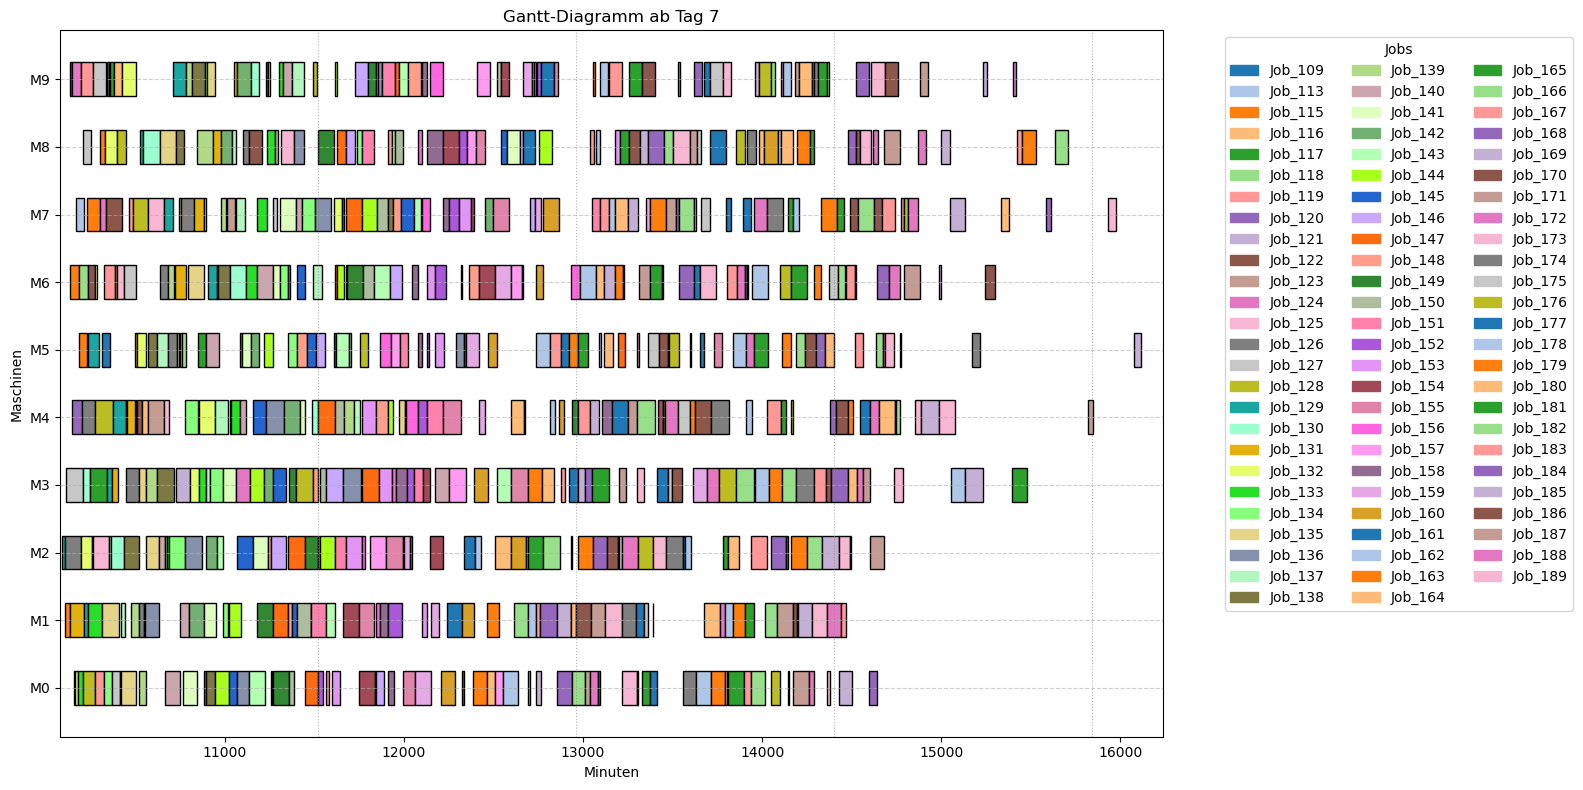

+ Keine Maschinenkonflikte gefunden
+ Für alle Jobs ist die Operationssequenz korrekt.
+ Zeitliche technologische Reihenfolge korrekt.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.

label
<-180           0
-180 - -120     0
-120 - -60      1
-60 - 0        11
0              63
0 - 60          1
60 - 120        0
120 - 180       1
>180            0
Name: count, dtype: int32
[168:11:00] Job_129 started on M2
[168:29:00] Job_115 started on M1
[168:30:00] Job_127 started on M3
[168:30:34] Job_129 finished on M2 (after 19 minutes 35 seconds)
[168:30:34] Job_126 started on M2
[168:47:42] Job_115 finished on M1 (after 18 minutes 42 seconds)
[168:55:00] Job_122 started on M9
[168:57:00] Job_131 started on M1
[168:57:00] Job_115 started on M6
[169:07:00] Job_120 started on M4
[169:09:57] Job_122 finished on M9 (after 14 minutes 57 seconds)
[169:09:57] Job_124 started on M9
[169:18:00] Job_129 started on M0
[169:24:55] Job_129 finished on M0 (after 06 m

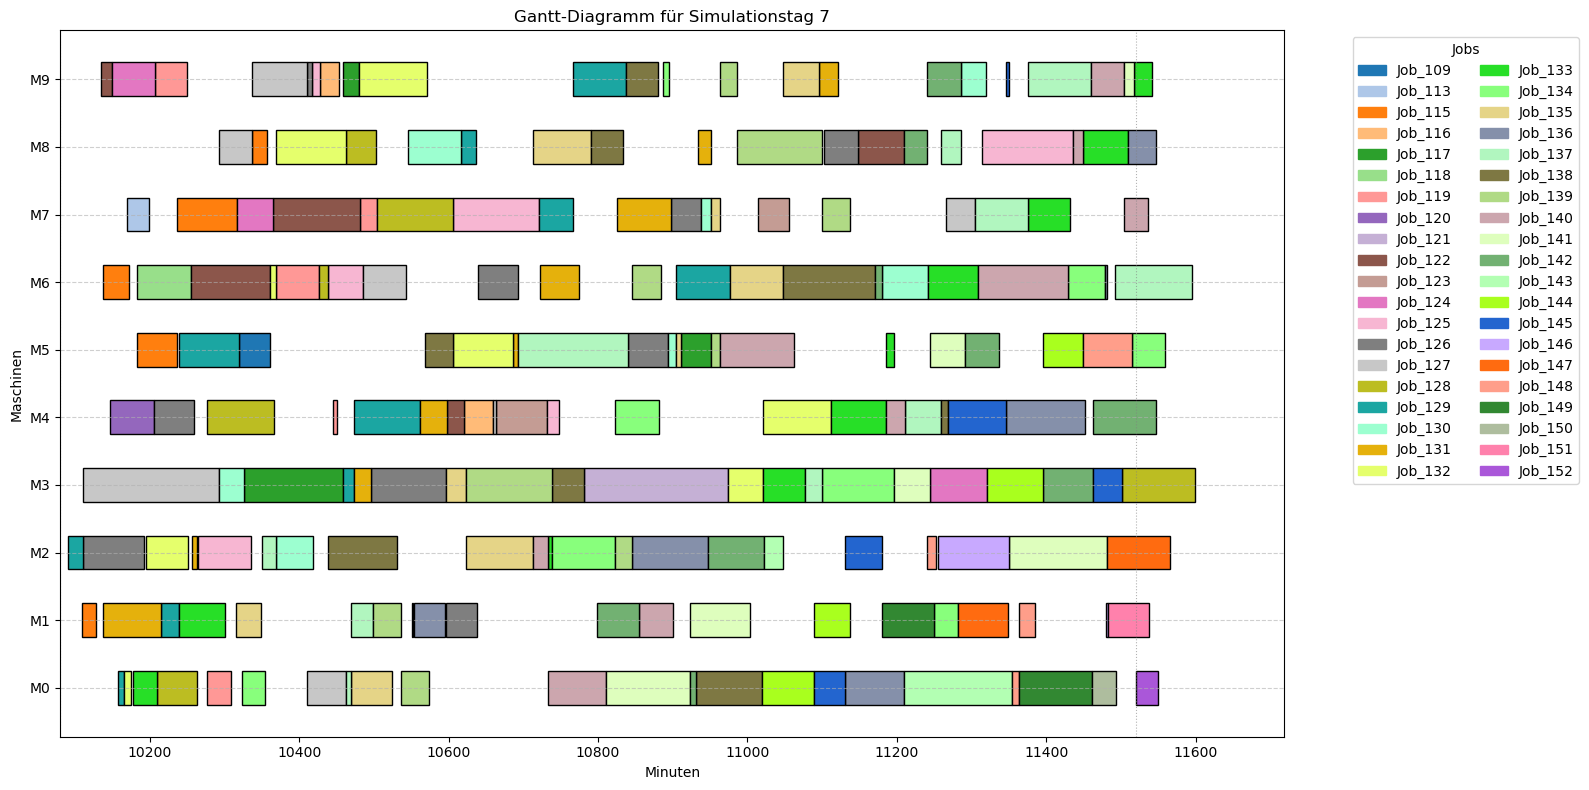

In [35]:
prefix_name = "06_devpen"
first_start = 1
last_planning_start = 7

df_plan = df_plan_init
df_execution = df_execution_init


for day_numb in range(first_start, last_planning_start + 1):
    day_start = day_length * day_numb
    day_end = day_start + day_length
    planning_end = day_start + horizon_days * day_length

    # ------------------- I. Ankunfts- und Operationsvorbereitung -------------------
    df_jssp_curr, df_times_curr = rp_proced.filter_jobs_by_arrival_window(df_times, df_jssp, day_start, planning_end)
    df_jssp_curr = rp_proced.extend_with_undone_operations(df_jssp_curr, df_undone)
    df_times_curr = rp_proced.update_times_after_operation_changes(df_times, df_jssp_curr)

    # ------------------- II. Relevante laufende Operationen -------------------------
    df_execution_important = rp_proced.get_operations_running_into_day(df_execution, day_start)

    # ------------------- III. Rescheduling durchführen -------------------------------

    starting_time = time.time()
    df_plan = solve_cp_jssp_lateness_by_tardiness_and_earliness_with_devpen(df_jssp_curr, df_times_curr, df_execution_important,
                                                                                 df_original_plan = df_plan, # prev. Plan
                                                                                 w_t = 5,
                                                                                 r = 0.70, # 70% Lateness, 30% Deviation
                                                                                 reschedule_start = day_start,
                                                                                 msg=False, timeLimit=max_time, gapRel= 0.05)

    
    solver_duration = time.time() - starting_time
    print(f"\n  Scheduling-Dauer: {int(solver_duration // 60)} Minuten und {(solver_duration % 60):.2f} Sekunden.")

    df_plan.to_csv(get_schedule_filename(prefix_name, day=day_numb), index=False)

    show.plot_gantt_machines(df_plan, title=f"Gantt-Diagramm ab Tag {day_numb}")
    check.check_constraints(df_plan)

    last_ops = df_plan.sort_values(['Job', 'Operation']).drop_duplicates('Job', keep='last')
    print(show.count_column_grouped(last_ops, "Lateness", max_val = 180, steps= 60))

    # ------------------- IV. Einen Tag simulieren -------------------------------------

    simulation = ProductionDaySimulation(df_plan, vc=0.35)
    df_execution, df_undone = simulation.run(start_time=day_start, end_time=day_end)
    if not df_execution.empty:
        show.plot_gantt_machines(df_execution, title=f"Gantt-Diagramm für Simulationstag {day_numb}", duration_column="Simulated Processing Time")
    else:
        print(f"Nothing executed on day {day_numb}")

In [ ]:
#notebook_duration = time.time() - start_notebook
#print(f"Dauer: {int(notebook_duration // 60)} Minuten und {(notebook_duration % 60):.2f} Sekunden.")